# Contrastive Training with Groove Radar

Train the StepMania difficulty classifier with contrastive learning using groove radar similarity.

**Multi-task learning:**
- Classification loss on anchor samples (CrossEntropy)
- Contrastive loss on triplets (TripletMarginLoss with adaptive margins)

**Key components:**
- `GrooveRadar`: DDR-style 5-value feature vector (Stream, Voltage, Air, Freeze, Chaos)
- `TripletSelector`: Selects positive/negative pairs based on groove radar similarity
- `ContrastiveTripletDataset`: Serves triplets for contrastive learning

In [26]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import json
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
# Import project modules
from src.data import (
    StepManiaDataset,
    ContrastiveTripletDataset,
    create_contrastive_dataset,
    DIFFICULTY_NAMES
)
from src.data.groove_radar import GrooveRadar
from src.data.similarity import GrooveRadarSimilarity, TripletSelector
from src.models.classifier import LateFusionClassifier
from src.training import ContrastiveTrainer

## 1. Configuration

In [36]:
# ===== EXPERIMENT SELECTION =====
# Choose which experiment to run:
# - 'A': Aggressive (freeze classifier head during warmup, downweight classification)
# - 'B': Conservative (selective unfreezing, freeze encoders only)
EXPERIMENT = 'B'  # Change to 'B' to run Experiment B

# Load appropriate configuration
if EXPERIMENT == 'A':
    config_path = Path('../config/contrastive_experiment_a.yaml')
    print("Running EXPERIMENT A: Aggressive (warmup + freeze classifier_head)")
elif EXPERIMENT == 'B':
    config_path = Path('../config/contrastive_experiment_b.yaml')
    print("Running EXPERIMENT B: Conservative (selective unfreezing)")
else:
    raise ValueError(f"Unknown experiment: {EXPERIMENT}. Must be 'A' or 'B'")

# Load configuration
with open(config_path, 'r') as f:
    full_config = yaml.safe_load(f)

classifier_config = full_config['classifier']
training_config = full_config['training']
contrastive_config = full_config['contrastive']
diagnostics_config = full_config.get('diagnostics', {})

print(f"\nConfiguration loaded from: {config_path}")
print("\n=== Classifier Config ===")
for k, v in classifier_config.items():
    if not isinstance(v, dict):
        print(f"  {k}: {v}")

print("\n=== Training Config (Key Settings) ===")
for k in ['batch_size', 'learning_rate', 'num_epochs', 'warmup_epochs',
          'warmup_cls_weight', 'finetune_cls_weight', 'selective_unfreeze']:
    if k in training_config:
        print(f"  {k}: {training_config[k]}")

print("\n=== Contrastive Config ===")
for k, v in contrastive_config.items():
    print(f"  {k}: {v}")

print("\n=== Diagnostics Config ===")
for k, v in diagnostics_config.items():
    print(f"  {k}: {v}")

Running EXPERIMENT B: Conservative (selective unfreezing)

Configuration loaded from: ../config/contrastive_experiment_b.yaml

=== Classifier Config ===
  audio_features_dim: 23
  chart_sequence_dim: 4
  max_sequence_length: 1440
  fusion_dim: 256
  num_classes: 4
  classifier_dropout: 0.2
  backbone_blocks: 4
  backbone_dropout: 0.4
  fusion_type: late
  pooling_type: mean_max
  head_type: classification
  classifier_hidden_dim: 64
  use_groove_radar: True
  radar_hidden_dim: 32
  radar_dropout: 0.3
  use_projection_head: True
  projection_dim: 128

=== Training Config (Key Settings) ===
  batch_size: 128
  learning_rate: 0.0001
  num_epochs: 20
  selective_unfreeze: ['fusion_module', 'backbone', 'pooling', 'classifier_head', 'projection_head', 'radar_mlp']

=== Contrastive Config ===
  enabled: True
  contrastive_loss: triplet_radar
  triplet_margin: 2.0
  margin_scale: 1.0
  infonce_temperature: 0.07
  classification_weight: 0.8
  contrastive_weight: 2.0
  positive_percentile: 15.0


In [4]:
# Dataset paths - update these for your environment
DATA_DIR = Path('../data')  # Parent directory containing chart folders
CHECKPOINT_DIR = Path('../checkpoints/contrastive')
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# Split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
  GPU: NVIDIA GeForce RTX 3060


## 2. Load Data

In [5]:
import glob
from sklearn.model_selection import train_test_split

# Find all chart files
chart_patterns = ['**/*.sm', '**/*.ssc']
chart_files = []
for pattern in chart_patterns:
    chart_files.extend(glob.glob(str(DATA_DIR / pattern), recursive=True))

print(f"Found {len(chart_files)} chart files")

# Split chart files into train/val/test
train_files, temp_files = train_test_split(
    chart_files, test_size=(VAL_RATIO + TEST_RATIO), random_state=42
)
val_files, test_files = train_test_split(
    temp_files, test_size=(TEST_RATIO / (VAL_RATIO + TEST_RATIO)), random_state=42
)

print(f"\nChart file splits:")
print(f"  Train: {len(train_files)}")
print(f"  Val: {len(val_files)}")
print(f"  Test: {len(test_files)}")

# Create datasets with cache enabled
max_seq_len = classifier_config.get('max_sequence_length', 1440)
cache_dir = training_config.get('cache_dir', 'cache/samples')

train_dataset = StepManiaDataset(
    chart_files=train_files,
    audio_dir=str(DATA_DIR),
    max_sequence_length=max_seq_len,
    cache_dir=f"{cache_dir}/train"
)

val_dataset = StepManiaDataset(
    chart_files=val_files,
    audio_dir=str(DATA_DIR),
    max_sequence_length=max_seq_len,
    cache_dir=f"{cache_dir}/val"
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} valid samples")
print(f"  Val: {len(val_dataset)} valid samples")

Found 6360 chart files

Chart file splits:
  Train: 4452
  Val: 954
  Test: 954
Parsing 4452 chart files...
squartatrice failed song length requirement
Howling the Nightmare (bms edit) failed song length requirement
Cube of mind failed song length requirement
ボッカデラベリタ failed song length requirement
Cross Galaxy failed song length requirement
Memoria(b-UMB HARDCORE MIX) failed bpm requirement (avg_bpm=205.0)
Missing Girl failed song length requirement
Cosmic Magic Shooter failed song length requirement
輝夜姫 failed song length requirement
Myself failed song length requirement
ボスとのレース failed song length requirement
KAERU failed bpm requirement (avg_bpm=229.2)
L.E.F. (Loud Electronic Ferocious) failed valid chart requirement (no dance-single charts)
We are the xxxx failed song length requirement
SPARKLiNG F!ZZ failed song length requirement
星屑の夜果て failed song length requirement
HYPER GIRLS GO! GO! failed valid chart requirement (no dance-single charts)
おでんぱ☆ラヴガール -BMS EDIT- failed song leng

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/128üπe980/128üπe980.sm: Audio file not found: ../data/community/remi/128üπe980/128e980.mp3
U.N.繧ｪ繝ｼ繧ｨ繝ｳ縺ｯ譚ｾ蟯｡菫ｮ騾縺ｪ縺ｮ縺具ｼｼｼ failed song length requirement
センダンライフ (かたぎり Bootleg) failed bpm requirement (avg_bpm=260.0)
Utopiangela (Cartoon Channel 203) failed bpm requirement (avg_bpm=203.0)
Ideal forever failed song length requirement
Bass Slut (Original Mix) failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/HAPPY｡ﾙLONG｡ﾙNOTES/ok.sm: Audio file not found: ../data/community/Mizuki's Simfiles/HAPPY｡ﾙLONG｡ﾙNOTES/HAPPYLUCKYBABY.mp3
Sayonara(ALL PHASE MIX) failed song length requirement
Error processing ../data/community/sabo/Jealousy of Green Eyes/Jealousy of Green Eyes.sm: Audio file not found: ../data/community/sabo/Jealousy of Green Eyes/05 Ί̃WFV[.mp3
☆虹色ロックンロール♪ Ex failed valid chart requirement (no dance-single charts)
next to you failed song length requirement
Error processing ../data/community/Gochamaze Greatest G

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Win The Race failed song length requirement
Twisted Drop Party failed song length requirement
Bug failed song length requirement
Qualia failed song length requirement
Error processing ../data/community/sabo/1111 (26)/111.sm: Audio file not found: ../data/community/sabo/1111 (26)/I̕P.mp3
Super Mario Brothers Main Theme failed bpm requirement (avg_bpm=218.0)
Little devil failed song length requirement
Heart To Heart(kors k Hardcore Remix) failed song length requirement
ギー太に首ったけ failed song length requirement
繧ｨ繧｢繝ｼ繝槭Φ縺悟偵○縺ｪ縺繧ｫ繝ｩ繧ｪ繧ｱ繝舌繧ｸ繝ｧ繝ｳ failed bpm requirement (avg_bpm=200.0)
Error processing ../data/community/sabo/25236/25236.sm: Audio file not found: ../data/community/sabo/25236/04 tOiCg.mp3
RESTRAINT failed song length requirement
sacrifice Love failed bpm requirement (avg_bpm=253.4)
縺ｪ縺ｪ縺ｍ縺ｳ繧医ｊ(YL-Beatz HandzUp Remix)Short Edit failed song length requirement
レンジで好吃☆電子調理器使用中華料理四千年歴史瞬間調理完了武闘的料理長☆ failed song length requirement
バンブーソード・ガール failed bpm requirement (avg_bpm=208.0)
Error

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Blooming failed song length requirement
holy night celebration failed song length requirement
Error processing ../data/community/remi/ù÷é╖éΘÉ_Æ╩ù═/ù÷é╖éΘÉ_Æ╩ù═.ssc: Audio file not found: ../data/community/remi/ù÷é╖éΘÉ_Æ╩ù═/_ʗ.mp3
恋せよ乙女! failed bpm requirement (avg_bpm=220.0)
砕月～天零萃夢 failed song length requirement
はなマルッ！ failed valid chart requirement (no dance-single charts)
Phantasm Brigade failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/Satori ｢ｦ3rd EyEs/Satori ｢ｦ3rd EyEs.sm: Audio file not found: ../data/community/Mizuki's Simfiles/Satori ｢ｦ3rd EyEs/Satori ～3rd EyEs.mp3
神話幻想～Infinite Being?
#SUBTITLE: failed song length requirement
Error processing ../data/community/remi/É»é╠éµéñé╔é╚éΦé╜éó/É»é╠éµéñé╔é╚éΦé╜éó.ssc: Audio file not found: ../data/community/remi/É»é╠éµéñé╔é╚éΦé╜éó/̂悤ɂȂ肽.mp3
Error processing ../data/community/sabo/U.N.½¬_½¿½≤¬╧∙¿╥│¬╩¬╬¬½ú┐ √⌡╪¬/U.N.½¬_½¿½≤¬╧∙¿╥│¬╩¬╬¬½ú┐ √⌡╪¬.sm: Audio file not found: ../data/community/sabo/U.N.½¬_½¿½≤¬╧

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Power 3 failed bpm requirement (avg_bpm=279.1)
Born failed song length requirement
get back here failed valid chart requirement (no dance-single charts)
包丁・ハサミ・カッター・ナイフ・ドス・キリ failed song length requirement
アーティミシアの空想舞踏科学 failed song length requirement
elegante failed song length requirement
Faith. failed song length requirement
Don't Come Crying failed song length requirement
旧地獄街道を行く ～反逆のパルスィ～ failed song length requirement
smile failed song length requirement
Moonside Criminal failed song length requirement
Moon-gate failed song length requirement
Planet Pulsation failed song length requirement
REMINISCENCE failed song length requirement
Error processing ../data/community/remi/ô±ÉlÉF-HEM mix-/ô±ÉlÉF-HEM mix-.sm: Audio file not found: ../data/community/remi/ô±ÉlÉF-HEM mix-/lF-HEM mix-.mp3
Error processing ../data/external/pack_38_6651b1/CAN'T TAKE MY EYES OFF YOU (70'S Remix)/CAN'T TAKE MY EYES OFF YOU (70'S Remix).sm: Audio file not found: ../data/external/pack_38_6651b1/CAN'T TAKE M

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


YOu＆ME=Happy! failed valid chart requirement (no dance-single charts)
Error processing ../data/external/pack_1292_1d20ff/Night of Knights (Ryu Remix)/Night of Knights (Ryu Remix).sm: Audio file not found: ../data/external/pack_1292_1d20ff/Night of Knights (Ryu Remix)/Night of knights (Ryu Remix).ogg
Scorpion Dance failed song length requirement
Error processing ../data/community/remi/éΦé╞éΘé▄éóé╖é─é┴é╒/éΦé╞éΘé▄éóé╖é─é┴é╒.ssc: Audio file not found: ../data/community/remi/éΦé╞éΘé▄éóé╖é─é┴é╒/Ƃ܂Ă.mp3
真・千年女王 failed song length requirement
Wireless Cosmic failed song length requirement
Error processing ../data/community/[Category Name Not Found]/[3.9] lifework/[3.9] lifework.sm: Audio file not found: ../data/community/[Category Name Not Found]/[3.9] lifework/lifework.mp3
Theme for Psychopath Justice failed song length requirement
Death Piano failed song length requirement
織姫(Independent from God, Everlasting love remix) failed song length requirement
Desert of Despair failed song length requ

Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/Raison d'etre ～交差する宿命～/Raison d'etre ～交差する宿命～.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/Raison d'etre ～交差する宿命～/Raison d'etre 󬪹٤.mp3
Wild Clown failed song length requirement
Error processing ../data/community/remi/éτé╘éτé╘üÖéΩé┌éΘü[é╡éσé±é╚éñüI/éτé╘éτé╘üÖéΩé┌éΘü[é╡éσé±é╚éñüI.sm: Audio file not found: ../data/community/remi/éτé╘éτé╘üÖéΩé┌éΘü[é╡éσé±é╚éñüI/Ԃԁڂ[ȂI.ogg
情熱のウォブル DJ SHIMAMURA Remix failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/L'amour et la liberte (DDR ver.)/L'amour et la liberte (DDR ver.).sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/L'amour et la liberte (DDR ver.)/L'amour et la liberte(DDR ver.).mp3
精霊剣舞祭 -Full ver- failed song length requirement
ライカ failed song length requirement
SigSig(ssry-ha2 mix) failed song length requirement
You'll you Lead failed song length requirement
Error proces

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Tragedy of the Sacred Kingdom failed song length requirement
Error processing ../data/community/Overcome CV Package2/(POWER_SEX)WNDER_LT_/WONDER $LOT 777.sm: Audio file not found: ../data/community/Overcome CV Package2/(POWER_SEX)WNDER_LT_/song.mp3
Error processing ../data/community/sabo/123/123.sm: Audio file not found: ../data/community/sabo/123/ٔ̎Eo̎.mp3
Error processing ../data/community/sabo/1111 (4)/111.sm: Audio file not found: ../data/community/sabo/1111 (4)/ׂĂ̎.mp3
elegante failed song length requirement
泥の分際で私だけの大切を奪おうだなんて failed bpm requirement (avg_bpm=225.0)
Canon Rock failed bpm requirement (avg_bpm=332.2)
Magical Love Words failed song length requirement
Jam & Marmalade failed song length requirement
09 Gtblessgo - Thaiboy Digital ft. Bladee failed song length requirement
Icyxis failed bpm requirement (avg_bpm=222.0)
Error processing ../data/community/remi/é╣é╚üÜé╣é╚@Surprise!!/é╣é╚üÜé╣é╚@Surprise!!.ssc: Audio file not found: ../data/community/remi/é╣é╚üÜé╣é╚@Surprise!!/

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


l'amour d'amour failed song length requirement
04 Still (prod. Avail) - Dion failed song length requirement
彼岸帰航-idling mix- failed song length requirement
Hau Ruck failed song length requirement
不思議の国のアリス failed song length requirement
Messier 333 failed song length requirement
Error processing ../data/community/sabo/Higan kikouííóª Riverside View/Higan kikouííóª Riverside View.sm: Audio file not found: ../data/community/sabo/Higan kikouííóª Riverside View/14 Higan kikou Riverside View.mp3
神さ?た?戦?～Suwa Foughten Field failed song length requirement
Error processing ../data/community/Sanatenshin/Faze to love/Faze to love.sm: Audio file not found: ../data/community/Sanatenshin/Faze to love/Faze to Love.mp3
Error processing ../data/community/sabo/parr/╘ñ¬δφ║¬╬╘▓∩╛¬¿¬┐╬Θ.sm: Audio file not found: ../data/community/sabo/parr/04 n҂̓r₦.mp3
Detector failed song length requirement
All I want for Christmas is you failed song length requirement
宇宙のMI'Sキッチン(Ras Remix) failed song length requiremen

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/âgâLâüâLâuü[âPâgâX/âgâLâüâLâuü[âPâgâX.ssc: Audio file not found: ../data/community/remi/âgâLâüâLâuü[âPâgâX/gLLu[PgX.mp3
Error processing ../data/community/remi/ò·ë█îπâXâgü[âLâôâO/ò·ë█îπâXâgü[âLâôâO.sm: Audio file not found: ../data/community/remi/ò·ë█îπâXâgü[âLâôâO/یXg[LO.mp3
ホワイトパレード failed bpm requirement (avg_bpm=218.0)
ツキソメ failed song length requirement
Ling Child (BMS Edit) failed song length requirement
DestinedMarionette failed song length requirement
Error processing ../data/community/sabo/Maid/âüâCâhé╞îîé╠ë∙ÆåÄ₧îv_2.sm: Audio file not found: ../data/community/sabo/Maid/10 Chƌ̉v.mp3
Happy☆Happy☆Fullmoon failed song length requirement
Error processing ../data/community/remi/ÆNé⌐æüé¡éáé╠Åùé≡Ä~é▀é─é¡éΩéÑé┴üI/ÆNé⌐æüé¡éáé╠Åùé≡Ä~é▀é─é¡éΩéÑé┴üI.sm: Audio file not found: ../data/community/remi/ÆNé⌐æüé¡éáé╠Åùé≡Ä~é▀é─é¡éΩéÑé┴üI/N̏~߂ĂꂥI.mp3
Oh Yah Kimochi failed song length requirement
Error processing ../data/community/sabo/1111 (15)/BGM5.sm: Audi

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/ô±ÉlÉF/ô±ÉlÉF.sm: Audio file not found: ../data/community/remi/ô±ÉlÉF/lF.mp3
Piano Concert No 666 failed bpm requirement (avg_bpm=283.2)
ゼフィランサス failed bpm requirement (avg_bpm=215.0)
Caixa D' Aqua failed bpm requirement (avg_bpm=264.0)
カ・ラ・ク・リ failed song length requirement
M3 failed song length requirement
Error processing ../data/community/sabo/ass/ass.sm: Audio file not found: ../data/community/sabo/ass/VV[̕.mp3
Parasitize Your Head failed song length requirement
ロミとロボの宇宙旅行 failed song length requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/The World of Scarlet ～ 血塗られた吸血姫/The World of Scarlet ～ 血塗られた吸血姫.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/The World of Scarlet ～ 血塗られた吸血姫/07 - The World of Scarlet �` ���h��ꂽ�z���P.mp3
conflict failed song length requirement
katharsis failed bpm requirement (avg_bpm=1004.1)
姫は乱気流☆御一行様 failed song length requirement
Farme Ta Yeule C

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/é═é┴é╥éíé╚é±é╛é⌐éτéóéóé╢éßé±/é═é┴é╥éíé╚é±é╛é⌐éτéóéóé╢éßé±.sm: Audio file not found: ../data/community/remi/é═é┴é╥éíé╚é±é╛é⌐éτéóéóé╢éßé±/͂҂Ȃ񂾂炢.mp3
CHASER failed song length requirement
spiral of despair -resurrection- failed song length requirement
Futari no Gomen ne failed song length requirement
Cartoon Candy failed bpm requirement (avg_bpm=320.5)
Error processing ../data/community/remi/ë╪ù∩Ex/ë╪ù∩.ssc: Audio file not found: ../data/community/remi/ë╪ù∩Ex/ؗ.mp3
Error processing ../data/community/remi/û∞ÅbâÅâCâïâh/û∞ÅbâÅâCâïâh.sm: Audio file not found: ../data/community/remi/û∞ÅbâÅâCâïâh/bCh.mp3
Error processing ../data/community/sabo/1254161236246/1254161236246.sm: Audio file not found: ../data/community/sabo/1254161236246/2-10 }WbNAJf~[g.mp3
信仰は儚き人間のために failed bpm requirement (avg_bpm=220.0)
neu failed song length requirement
あいさつの魔法。 failed song length requirement
Orbital Period failed song length requirement
Inside of the uroboros failed song 

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


ハウトゥワープ failed song length requirement
四角革命 failed song length requirement
女神ノ宿命 failed song length requirement
コーティングチョコ failed song length requirement
Infinity failed song length requirement
Error processing ../data/community/sabo/Unknown/Unknown.sm: Audio file not found: ../data/community/sabo/Unknown/09. fBUXggLX^[.mp3
Record one's Dream failed song length requirement
Baby failed valid chart requirement (no dance-single charts)
乙女繚乱 舞い咲き誇れ failed bpm requirement (avg_bpm=210.0)
next to you failed song length requirement
Apomnhmoneumai failed song length requirement
Error processing ../data/community/sabo/1111 (21)/111.sm: Audio file not found: ../data/community/sabo/1111 (21)/ハイセンスナンセンス.mp3
硝子のLoneliness failed song length requirement
Radar failed song length requirement
VALLIS-NERIA failed song length requirement
TIME LIMIT(bms edit) failed song length requirement
Angel dust failed song length requirement
F failed song length requirement
Error processing ../data/community/remi/ù÷é

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


夜な夜な夜な ファミコン"風"アレンジ failed song length requirement
たむたむ☆かすたむたいむ failed valid chart requirement (no dance-single charts)
Moon-gate failed song length requirement
(･ω･▽derful♥Valentine failed bpm requirement (avg_bpm=206.0)
02 mixd up - i9bonsai feat. Blackwinterwells & 8485 failed song length requirement
Error processing ../data/community/remi/âïü[ârâbâNâLâàü[âu/âïü[ârâbâNâLâàü[âu.sm: Audio file not found: ../data/community/remi/âïü[ârâbâNâLâàü[âu/[rbNL[u.mp3
doll miraceti failed song length requirement
Error processing ../data/community/remi/éñé│é╩é▒é╩é±é╩é±âtâ@âôâ^âWü[üI/éñé│é╩é▒é╩é±é╩é±âtâ@âôâ^âWü[üI.sm: Audio file not found: ../data/community/remi/éñé│é╩é▒é╩é±é╩é±âtâ@âôâ^âWü[üI/ʂʂʂt@^W[I.mp3
Canon blazing summer mix failed song length requirement
Air failed song length requirement
闖ｯ闢ｮ迯 - Un-Flowering-Night failed song length requirement
Error processing ../data/community/sabo/1245/1245.sm: Audio file not found: ../data/community/sabo/1245/09 NgK[`.mp3
POSSESSION (20th Anniversary M

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Samurai Shogun vs. Master Ninja failed bpm requirement (avg_bpm=260.0)
%E3%83%96%E3%83%B3%E3%82%BF%E3%83%B3 ～Falling in 'B' mix～ failed bpm requirement (avg_bpm=426.2)
Why We Lose failed song length requirement
夜な夜な夜な failed song length requirement
Blue Dragoon failed song length requirement
トレジャーチルノ failed bpm requirement (avg_bpm=217.0)
Error processing ../data/community/sabo/ELECTRO SYLPHSF-A2 MIKI/ELECTRO SYLPHSF-A2 MIKI.sm: Audio file not found: ../data/community/sabo/ELECTRO SYLPHSF-A2 MIKI/ELECTRO SYLPH^SF-A2 MIKI.mp3
Error processing ../data/community/-Silenttype01's DDR Edits-/SP-TRIP MACHINE ~JUNGLE MIX~/SP-TRIP MACHINE ~JUNGLE MIX~.sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/SP-TRIP MACHINE ~JUNGLE MIX~/SP-TRIP MACHINE(JUNGLE MIX).mp3
Odin failed song length requirement
GERBERA failed bpm requirement (avg_bpm=205.0)
06 (mknrmx) failed song length requirement
INFINITY failed valid chart requirement (no dance-single charts)
Beat of the Rising Sun fai

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:INT123_parse_new_id3():1113] warning: ID3v2: skipping invalid/unsupported frame
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Angel dust failed song length requirement
Error processing ../data/community/sabo/1111 (14)/BGM2.sm: Audio file not found: ../data/community/sabo/1111 (14)/R[vXp[eB[ BGM2.mp3
Epsilon-Delta failed song length requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/鋼鉄マスタースパーク/鋼鉄マスタースパーク.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/鋼鉄マスタースパーク/02 - �|�S�}�X�^�[�X�p�[�N.mp3
Lunatic Diamond failed song length requirement
The Rise of Pre-teen Homosexuals failed song length requirement
MAX 300 failed bpm requirement (avg_bpm=305.3)
はちみーのうた(simoyuki Remix) failed song length requirement
Hypertext Transfer Protocol failed song length requirement
oblivion～輪廻～ failed song length requirement
Lamir failed song length requirement
Error processing ../data/community/sabo/1111 (37)/111.sm: Audio file not found: ../data/community/sabo/1111 (37)/䗬Yz.mp3
ぴゅあぴゅあはーと failed song length requirement
ドーナツホール failed bpm requirement (avg_bpm=252.0)


[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/stapmania full package/complexイマージュ/complex imaju.sm: Audio file not found: ../data/community/stapmania full package/complexイマージュ/コンプレックス･イマージュ歌わせてみた.mp3
SUPERNOVA failed song length requirement
幼稚園9月号 failed song length requirement
Error processing ../data/community/sabo/REDDD music select Medley/REDDD music select Medley.sm: Audio file not found: ../data/community/sabo/REDDD music select Medley/RED`DD music select Medley.mp3
Error processing ../data/community/sabo/Shonyun A/Shonyun A.sm: Audio file not found: ../data/community/sabo/Shonyun A/NA.mp3
TIEFSEE failed song length requirement
F failed song length requirement
Error processing ../data/community/remi/âXâ^ü[â`âX/âXâ^ü[â`âX.ssc: Audio file not found: ../data/community/remi/âXâ^ü[â`âX/X^[`X.mp3
Error processing ../data/community/remi/âqâ~âcâmâ~âëâC/âqâ~âcâmâ~âëâC.sm: Audio file not found: ../data/community/remi/âqâ~âcâmâ~âëâC/q~cm~C.mp3
orion failed song length requirement
Rigid Paradise failed

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Re：Pray failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/DYNAMITE RAVE (B4 ZA BEAT MIX)/DYNAMITE RAVE (B4 ZA BEAT MIX).sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/DYNAMITE RAVE (B4 ZA BEAT MIX)/DYNAMITE RAVE(B4 ZA BEAT MIX).mp3
探偵弱音ハクの憂鬱 failed song length requirement
SHINE RING failed song length requirement
スペックだけ使い切ったゲームソフトのようですぅ failed song length requirement
ようこそルナルティアへ failed valid chart requirement (no dance-single charts)
メギツネ failed song length requirement
FairyJoke failed valid chart requirement (no dance-single charts)
SEITEN NO TERIYAKI failed bpm requirement (avg_bpm=273.0)
Ray of Moonlight failed song length requirement
Stargaze failed song length requirement
Error processing ../data/community/remi/natsuno_owari/basic.sm: Audio file not found: ../data/community/remi/natsuno_owari/Ă̏I_short.mp3
Error processing ../data/community/-Silenttype01's DDR Edits-/rainbow rainbow/rainbow rainbow.sm: Audio file n

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/sabo/7th10th EX music select Medley/7th10th EX music select Medley.sm: Audio file not found: ../data/community/sabo/7th10th EX music select Medley/7th`10th EX music select Medley.mp3
Nemesis failed bpm requirement (avg_bpm=222.0)
Killer Queen failed song length requirement
Error processing ../data/community/sabo/3rd6th music select Medley/3rd6th music select Medley.sm: Audio file not found: ../data/community/sabo/3rd6th music select Medley/3rd`6th music select Medley.mp3
Catch the Moment failed song length requirement
ギバラ「しNE-eeeeeeeeee AAAAE-A-A-I-A-U- YO-oooooooooooo」 failed song length requirement
NONSTOP E failed song length requirement
繝阪け繝ｭ繝輔ぃ繝ｳ繧ｿ繧ｸ繧｢ AzelAsh繧｢繝ｬ繝ｳ繧ｸ failed song length requirement
Calamity Fortune failed song length requirement
On GP failed song length requirement
あの世行きのバスに乗ってさらば。 failed bpm requirement (avg_bpm=240.0)
CandyPop-Love failed valid chart requirement (no dance-single charts)
Error processing ../data/community/#JPeni

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


シークレットミッション～ホントの気持ち～ failed song length requirement
Fuck You One More Time failed bpm requirement (avg_bpm=308.1)
Twin memories W failed song length requirement
TRUTH and FATE failed song length requirement
Scotty doesnt know failed valid chart requirement (no dance-single charts)
Shade of Gloria failed bpm requirement (avg_bpm=241.2)
20031023 failed song length requirement
Waterfalls Coming Out Your Mouth failed song length requirement
LOVE✩FIRE! failed song length requirement
L.L.L. failed bpm requirement (avg_bpm=208.0)
Candy Cream (tpz Overcute Remix) failed song length requirement
Error processing ../data/community/#774 Etterna Explosion Excitepack/Jumper (Xingyue)/Jumper.sm: Audio file not found: ../data/community/#774 Etterna Explosion Excitepack/Jumper (Xingyue)/jumper.mp3
Infinite Galaxy failed song length requirement
Grin failed song length requirement
Error processing ../data/community/sabo/1111 (50)/111.sm: Audio file not found: ../data/community/sabo/1111 (50)/03. ȏȌ.mp3
l

システム零 failed song length requirement
ROTTERDAM ENTER failed song length requirement
SERIOUS ERROR failed bpm requirement (avg_bpm=240.0)
Dong! Dong! failed bpm requirement (avg_bpm=210.0)
Saturday failed song length requirement
Error processing ../data/community/sabo/1111 (11)/11.sm: Audio file not found: ../data/community/sabo/1111 (11)/09. LveET.mp3
Freja failed song length requirement
Decoy failed song length requirement
Hunch Gray failed song length requirement
アランドラ(メインテーマ) failed song length requirement
eth剣 failed song length requirement
君に届くまで failed song length requirement
Remain failed bpm requirement (avg_bpm=202.1)
angel's tear failed song length requirement
友情＞＞＞(越えられない壁)＞＞＞恋愛 failed song length requirement
Error processing ../data/community/sabo/Union Dragon/Union Dragon.sm: Audio file not found: ../data/community/sabo/Union Dragon/96-jIhS.mp3
Kung-fu Empire failed song length requirement
Error processing ../data/community/[Category Name Not Found]/[3.9] HEAVENLY MOON (Sa

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


茉子の日常 failed valid chart requirement (no dance-single charts)
Gamegame(bms edit) failed song length requirement
New Era failed bpm requirement (avg_bpm=307.5)
Error processing ../data/community/sabo/The Battle with Death-/The Battle with Death-.sm: Audio file not found: ../data/community/sabo/The Battle with Death-/3-06 ւ̏ҏ -The Battle with Death-.mp3
HAELEQUIN failed song length requirement
RememberU failed bpm requirement (avg_bpm=200.0)
妄想感傷代償連盟 failed bpm requirement (avg_bpm=220.0)
Error processing ../data/community/remi/ù÷é╖éΘÄoûàüÖâëüÖÿZÅdætEx/ù÷é╖éΘÄoûàüÖâëüÖÿZÅdætEx.ssc: Audio file not found: ../data/community/remi/ù÷é╖éΘÄoûàüÖâëüÖÿZÅdætEx/oZdtEx.mp3
THE SHINING POLARIS (kors k mix) failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/TRIP MACHINE survivor/TRIP MACHINE survivor.sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/TRIP MACHINE survivor/TRIP MACHINE Survivor.mp3
melody... failed song length requirement
HE

雷洸 -3rd Desire- failed song length requirement
B-T failed song length requirement
Spread Wings.(REDCocktail Hardcore Remix) failed song length requirement
Alice failed song length requirement
Dead Fantasia failed song length requirement
Error processing ../data/community/Sanatenshin/ÅáLOVERS/ÅáLOVERS.sm: Audio file not found: ../data/community/Sanatenshin/ÅáLOVERS/∞LOVERS.mp3
ULTiMATE INFLATiON failed bpm requirement (avg_bpm=451.0)
Error processing ../data/external/pack_356_e3e829/PUT YOUR FAITH IN ME (SATURDAY NIGHT MIX)/PUT YOUR FAITH IN ME (SATURDAY NIGHT MIX).sm: Audio file not found: ../data/external/pack_356_e3e829/PUT YOUR FAITH IN ME (SATURDAY NIGHT MIX)/PUT YOUR FAITH IN ME (SATURDAY NIGHT MIX).OGG
DENGEKI Tube failed valid chart requirement (no dance-single charts)
It's "alice" dream failed song length requirement
Pokemon Battle Dimension failed song length requirement
Everything Black (feat. Mike Taylor) (Envy Frenchcore) failed bpm requirement (avg_bpm=261.6)
百鬼飛行
#SUBTITL

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Gracias failed bpm requirement (avg_bpm=273.6)
Miss.Brand-new day failed song length requirement
Error processing ../data/community/sabo/1111 (60)/111.sm: Audio file not found: ../data/community/sabo/1111 (60)/15. ̃GCA.mp3
Error processing ../data/community/remi/Å¡Åùé╠ï≤öÆâvâèâYâô/Å¡Åùé╠ï≤öÆâvâèâYâô.ssc: Audio file not found: ../data/community/remi/Å¡Åùé╠ï≤öÆâvâèâYâô/̋󔒃vY.mp3
輪廻転生 failed song length requirement
daidaidaidaidaidaidaidaidaidaisuki failed song length requirement
YuuKaing De Metal Bokunai Nanika failed song length requirement
超☆超☆光☆速☆出☆前☆最☆速!!! スピード★スター★かなで failed bpm requirement (avg_bpm=4937.2)
Piece of Time failed song length requirement
furioso melodia failed song length requirement
ルマ failed song length requirement
MA-N-KI-TSU! failed valid chart requirement (no dance-single charts)
天????暁??? failed song length requirement
Lifeline failed bpm requirement (avg_bpm=212.0)
REIMU2RAVE failed song length requirement
Error processing ../data/community/sabo/12415125/12415125

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


ケモノノダンス failed bpm requirement (avg_bpm=210.0)
Error processing ../data/community/remi/û▓ë╘ë╬/û▓ë╘ë╬.ssc: Audio file not found: ../data/community/remi/û▓ë╘ë╬/ԉ.mp3
Error processing ../data/community/sabo/1111 (35)/111.sm: Audio file not found: ../data/community/sabo/1111 (35)/02 ̎q.mp3
チルノのパーフェクトさんすう教室 failed song length requirement
Error processing ../data/community/Sanatenshin/(sanatenshin)Red - reduction division - Sat vs Tkm RMX ver.2.1/Red - reduction division - Sat vs Tkm RMX ver.2.1.sm: Audio file not found: ../data/community/Sanatenshin/(sanatenshin)Red - reduction division - Sat vs Tkm RMX ver.2.1/Red - Reduction division - Sat vs Tkm RMX ver.2.1.mp3
Candy & Baguette failed song length requirement
Legendary failed song length requirement
JAG 2 Hall failed song length requirement
Error processing ../data/community/sabo/CaptivAte2èoÉ┴/CaptivAte2èoÉ┴.sm: Audio file not found: ../data/community/sabo/CaptivAte2èoÉ┴/CaptivAte2`o`.mp3
星の器 ～STAR OF ANDROMEDA～ failed song length requir

ちっちゃらぶ failed valid chart requirement (no dance-single charts)
Bicolor Spirit failed song length requirement
Conflict failed song length requirement
FREEDOM DiVE↓ failed bpm requirement (avg_bpm=222.2)
Error processing ../data/community/sabo/1111 (13)/11.sm: Audio file not found: ../data/community/sabo/1111 (13)/OEAbv.mp3
Error processing ../data/community/remi/guruüçguru/guruüçguru.sm: Audio file not found: ../data/community/remi/guruüçguru/guru∞guru.mp3
諱先門ｰ大･ｳX failed song length requirement
Don't You Worry Child failed song length requirement
Blew My Mind failed bpm requirement (avg_bpm=352.2)
Satirize failed song length requirement
Vanished Truth failed bpm requirement (avg_bpm=200.5)
Final Answer failed song length requirement
Black Lair failed song length requirement
Co-Pilot failed song length requirement
Pokemon battle imaging - No.3 failed bpm requirement (avg_bpm=205.0)
Flower Lips failed song length requirement
Sky is the Limit failed song length requirement
NOISY LOVE POWE

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Criminal Yuan-Sheng failed song length requirement
StarRail failed song length requirement
Ray of bullet -Full ver- failed song length requirement
la noche failed song length requirement
縲朱｢ｨ逾槫ｰ大･ｳ縲 failed song length requirement
Error processing ../data/external/pack_38_6651b1/BOOM BOOM DOLLAR (K.O.G G3 MIX)/BOOM BOOM DOLLAR (K.O.G G3 MIX).sm: No audio filename provided in chart metadata
Healing Vision failed bpm requirement (avg_bpm=289.6)
カラフル オーケストラアレンジ failed song length requirement
R.I.P. failed bpm requirement (avg_bpm=270.0)
To (HAPPY mix) failed song length requirement
ジャンプアップ↑エール！！ failed bpm requirement (avg_bpm=212.0)
Mirage Garden failed song length requirement
Precious Line failed valid chart requirement (no dance-single charts)
Erase failed song length requirement
ALice-DoLL failed song length requirement
あなた failed song length requirement
Error processing ../data/community/remi/Å¡Åùé╠ï≤öÆâvâèâYâô/Å¡Åùé╠ï≤öÆâvâèâYâô.sm: Audio file not found: ../data/community/remi/Å¡Åùé╠

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Recharge Your Resonator failed song length requirement
The Ultimate Challenge failed song length requirement
俺と彼女がミステリーな件について failed song length requirement
Necro Fantasia failed bpm requirement (avg_bpm=250.0)
Error processing ../data/community/Sanatenshin/(sanatenshin)Magus night  Frenzy Night/Magus night  Frenzy Night.sm: Audio file not found: ../data/community/Sanatenshin/(sanatenshin)Magus night  Frenzy Night/Magus night Frenzy Night.mp3
Tell The Truth failed song length requirement
Fatally failed song length requirement
Error processing ../data/community/Overcome CV Package2/(CCC)memento/memento.sm: Audio file not found: ../data/community/Overcome CV Package2/(CCC)memento/memento.mp3
Border of extacy failed bpm requirement (avg_bpm=204.0)
RockOnYou failed song length requirement
万戈イム一一ノ十 failed bpm requirement (avg_bpm=6103.9)
winterSHIKI-四季より第一楽章 failed song length requirement
Disabled the FLAW failed song length requirement
お兄ちゃん、右手の使用を禁止します! failed song length requirement
neve

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/ÄKé╤é╜îÄé╞Æeè█/ÄKé╤é╜îÄé╞Æeè█.sm: Audio file not found: ../data/community/remi/ÄKé╤é╜îÄé╞Æeè█/Kтƒe.mp3
Canon (blazing summer mix) failed song length requirement
ぼくらの１６bit戦争 failed bpm requirement (avg_bpm=251.4)
Papillon failed song length requirement
祝祭のエレメンタリア -クレアver- failed song length requirement
ルミナスデイズ failed song length requirement
full-consciousness green failed valid chart requirement (no dance-single charts)
Error processing ../data/community/sabo/Luna Dial (DJ TEKK REMIX)/Luna Dial (DJ TEKK REMIX).sm: Audio file not found: ../data/community/sabo/Luna Dial (DJ TEKK REMIX)/v`iE_CA (DJT TEKK REMIX).mp3
SunnyShinyRing failed song length requirement
ADDicTiON4500000 failed song length requirement
Error processing ../data/community/remi/ù÷é≡é╡éµü[éµ/ù÷é≡é╡éµü[éµ.ssc: Audio file not found: ../data/community/remi/ù÷é≡é╡éµü[éµ/[.mp3
WiLL failed song length requirement
Error processing ../data/community/remi/PeaceüùPieces/PeaceüùPieces.ssc: Aud

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


恐鳥 failed song length requirement
テイルズ・オブ・ナイツ failed song length requirement
夕立のりぼん failed bpm requirement (avg_bpm=230.0)
Resurrection Spell failed bpm requirement (avg_bpm=3795.7)
Last Chance failed bpm requirement (avg_bpm=219.3)
ドタ☆バタ紅魔館 failed song length requirement
Bright Pain failed song length requirement
らぶ撮りハレーション failed valid chart requirement (no dance-single charts)
Error processing ../data/community/remi/âRâRâìücÉ░éΩ/âRâRâìücÉ░éΩ.ssc: Audio file not found: ../data/community/remi/âRâRâìücÉ░éΩ/RRc.mp3
青と夏 failed bpm requirement (avg_bpm=240.0)
EXILE failed song length requirement
true DJ MAG top ranker's song Zenpen (katagiri Remix) failed song length requirement
R30 failed bpm requirement (avg_bpm=220.0)
Error processing ../data/community/remi/BeüÖHappy!/BeüÖHappy!.ssc: Audio file not found: ../data/community/remi/BeüÖHappy!/BeHappy!.mp3
Error processing ../data/community/remi/é╙éΩéáüÖé▒é±é╒éΩé┴é¡é╖/é╙éΩéáüÖé▒é±é╒éΩé┴é¡é╖.ssc: Audio file not found: ../data/community/remi/

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/ù÷é╖éΘÉXé╠faily tale/ù÷é╖éΘÉXé╠faily tale.sm: Audio file not found: ../data/community/remi/ù÷é╖éΘÉXé╠faily tale/Xfaily tale.mp3
MA.DA.KA.NA. MAKAIWARS failed bpm requirement (avg_bpm=235.0)
Necro Fantasia failed bpm requirement (avg_bpm=352.4)
Error processing ../data/community/sabo/½╧_½╚½╒½º½δ½╚½╒½í½≤½╖_/½╧_½╚½╒½º½δ½╚½╒½í½≤½╖_.sm: Audio file not found: ../data/community/sabo/½╧_½╚½╒½º½δ½╚½╒½í½≤½╖_/08 n[gtFgt@V[.mp3
Precious Time failed song length requirement
瞬間スプライン failed valid chart requirement (no dance-single charts)
Error processing ../data/community/[Category Name Not Found]/[3.9] The Limbo/[3.9] The Limbo.sm: Audio file not found: ../data/community/[Category Name Not Found]/[3.9] The Limbo/The Limbo.mp3
恋の2-4-11(BMS Edit) failed song length requirement
PRAY 2 DA REDMOON failed song length requirement
Glantz failed song length requirement
subconsciousness failed bpm requirement (avg_bpm=407.0)
ひかりふる failed bpm requirement (avg_bpm=55.1)
u

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Piano x Forte x Scandal failed song length requirement
Error processing ../data/community/sabo/111/1.sm: Audio file not found: ../data/community/sabo/111/cLmLIN.mp3
アニソンメドレー -彩- failed song length requirement
Lachryma《Re\:Queen’M》 failed bpm requirement (avg_bpm=236.0)
Answer failed song length requirement
Ms.Naive Princess failed song length requirement
Error processing ../data/community/Sanatenshin/koizakura/Koizakura.sm: Audio file not found: ../data/community/Sanatenshin/koizakura/koizakura.mp3
Battle Field failed song length requirement
Error processing ../data/community/sabo/Chengong/Chengong.sm: Audio file not found: ../data/community/sabo/Chengong/V]Ԓ@.mp3
Error processing ../data/community/stapmania full package/Just Dance/stapmania/モンスターハウス/モンスターハウス.sm: Audio file not found: ../data/community/stapmania full package/Just Dance/stapmania/モンスターハウス/ポケダン 青 モンスターハウス.mp3
Error processing ../data/community/remi/â_â`âRé╠ìKé╣é╚ô·Åφ/â_â`âRé╠ìKé╣é╚ô·Åφ.sm: Audio file not found: ../data/c

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


SUPER SUMMER DIVE!! failed song length requirement
Error processing ../data/community/remi/âcü[âfâBü[üÜ/âcü[âfâBü[üÜ.ssc: Audio file not found: ../data/community/remi/âcü[âfâBü[üÜ/c[fB[.mp3
Error processing ../data/community/remi/GHOSTü~GRADUATION/GHOSTü~GRADUATION.ssc: Audio file not found: ../data/community/remi/GHOSTü~GRADUATION/GHOST~GRADUATION.mp3
Crazy Baby failed bpm requirement (avg_bpm=441.1)
Pure My Voices failed song length requirement
Little bravery failed song length requirement
Imaginary affair failed song length requirement
G e n g a o z o failed song length requirement
PEACE BREAKER failed song length requirement
T.S ： Terminal Strike failed song length requirement
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(RION)Fatima/Fatima.sm: Audio file not found: ../data/community/Gochamaze Greatest Gigapack 2/(RION)Fatima/fatima.ogg
NEVER ENDING LIGHT failed song length requirement
More Selfish failed song length requirement
Dreht Sich！ failed song length re

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/öwÉàöVÉw/öwÉàöVÉw.sm: Audio file not found: ../data/community/remi/öwÉàöVÉw/wVw.mp3
星の器 ～STAR OF ANDROMEDA～ failed song length requirement
Comfort BLAST failed bpm requirement (avg_bpm=289.9)
Love's Rebirth '06 failed song length requirement
Realize Maze failed song length requirement
Rendezvous failed song length requirement
Ereshkigal failed song length requirement
Free failed song length requirement
夜に駆ける failed song length requirement
Fire In The Sky failed song length requirement
LUVディテクター failed song length requirement
Icarus failed song length requirement
終焉り紡ぎし者 failed bpm requirement (avg_bpm=250.0)
Death By Glamour failed song length requirement
FANTASTIC ILLUSION failed song length requirement
K Lobelia failed song length requirement
カ・ラ・ク・リ failed song length requirement
Error processing ../data/community/remi/é¿îZé┐éßé±üAëEÄΦé╠Ägùpé≡ï╓Ä~é╡é▄é╖Ex/é¿îZé┐éßé±üAëEÄΦé╠Ägùpé≡ï╓Ä~é╡é▄é╖.ssc: Audio file not found: ../data/community/remi/é¿îZ

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/remi/ÅεöMé╠âöâHâuâï/ÅεöMé╠âöâHâuâï.ssc: Audio file not found: ../data/community/remi/ÅεöMé╠âöâHâuâï/M̃Hu.mp3
Error processing ../data/community/remi/ié≡ë≡é½é╚é│éó/ié≡ë≡é½é╚é│éó.sm: Audio file not found: ../data/community/remi/ié≡ë≡é½é╚é│éó/iȂ.mp3
Жаз failed song length requirement
Girl's spirit failed valid chart requirement (no dance-single charts)
Cinderella Story failed song length requirement
Error processing ../data/community/sabo/1111 (40)/Cosmic Mind.sm: Audio file not found: ../data/community/sabo/1111 (40)/13. ̖VO@` Cosmic Mind.mp3
kiss me kiss to you failed valid chart requirement (no dance-single charts)
Don't let you down failed song length requirement
Romantic Loneliness failed song length requirement
エガオノキミヘ failed song length requirement
あの娘にドロップキック failed bpm requirement (avg_bpm=221.2)
Imperishable Night 2006 failed song length requirement
Sway failed song length requirement
Together As One failed song length requirement
Baby Fantasti

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Aihana(Love+ Edit) failed song length requirement
Central DELAY failed song length requirement
Error processing ../data/community/remi/â^âCâêâEâpâëâ_âCâXEx/â^âCâêâEâpâëâ_âCâX.sm: Audio file not found: ../data/community/remi/â^âCâêâEâpâëâ_âCâXEx/^CEp_CX.mp3
The Island of Albatross failed song length requirement
Scorpion Dance failed song length requirement
For Life failed song length requirement
Lyrith -迷宮リリス- failed song length requirement
Vision～雪の季節～ failed song length requirement
Dreaming in library failed song length requirement
エンバディメント ～2010 flynation mix～ failed song length requirement
READY!! failed song length requirement
カラフルストーリー Full ver failed song length requirement
Air failed song length requirement
Error processing ../data/community/-Silenttype01's DDR Edits-/CELEBRATE NITE (EURO TRANCE STYLE)/CELEBRATE NITE (EURO TRANCE STYLE).sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/CELEBRATE NITE (EURO TRANCE STYLE)/CELEBRATE NITE(EURO TRANCE STYLE).mp3


[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


チルノのパーフェクトさんすう教室(EDM REMIX) failed song length requirement
Utauyo!!MIRACLE (Eurobeat Mix) failed song length requirement
こぉのしｗなｗやｗかｗなｗぼでぃｗｗｗ failed song length requirement
Verflucht failed valid chart requirement (no dance-single charts)
Error processing ../data/community/sabo/1111 (9)/111.sm: Audio file not found: ../data/community/sabo/1111 (9)/IṼX.mp3
は！か！た！の！しお！ failed song length requirement
?知???信仰～Nuclear Fusion failed song length requirement
Error processing ../data/community/remi/ÅIûûé≡Æ╟éñÄ╥/ÅIûûé≡Æ╟éñÄ╥.sm: Audio file not found: ../data/community/remi/ÅIûûé≡Æ╟éñÄ╥/Iǂ.mp3
Stars Biscuit failed song length requirement
永遠なる絆と想いのキセキ failed song length requirement
プリズマティックプリンセス☆ユニゾンスターズ failed valid chart requirement (no dance-single charts)
Girl meets Love Ex failed valid chart requirement (no dance-single charts)
ΔMAX failed bpm requirement (avg_bpm=769.2)
Lunatic of the Full-Moon failed song length requirement
物凄いライヴでチルノがそこはかとなく物凄いうた failed bpm requirement (avg_bpm=220.0)
KHAM

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


幽霊東京 failed song length requirement
ロケット✩ライド -Full ver- failed song length requirement
天風 failed song length requirement
Aihana(Radio Edit) failed song length requirement
Error processing ../data/community/sabo/suimusou/╘╘█░⌡■┘╙▀╠.sm: Audio file not found: ../data/community/sabo/suimusou/2-19 z.mp3
Jade Star failed song length requirement
elegante failed song length requirement
六兆年と一夜物語～ピアノアレンジ～ failed song length requirement
blue traces [*>ω<*] failed song length requirement
Error processing ../data/community/sabo/1111 (68)/111.sm: Audio file not found: ../data/community/sabo/1111 (68)/T[L[V.mp3
Error processing ../data/community/sabo/Mooned Insect/σ┐üXÅHîÄ   Mooned Insect.sm: Audio file not found: ../data/community/sabo/Mooned Insect/03 忁XH  ` Mooned Insect.mp3
Architecture failed bpm requirement (avg_bpm=300.0)
Ascension to Heaven failed song length requirement
Despre tine failed valid chart requirement (no dance-single charts)
Give It To Dem failed song length requirement
祝祭のエレメンタ

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


MAX 360 failed bpm requirement (avg_bpm=360.2)
創傷イノセンス failed bpm requirement (avg_bpm=205.0)
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/水橋ジェラシックパーク/水橋ジェラシックパーク.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/水橋ジェラシックパーク/WFVbNp[N.ogg
Change&Chance! failed valid chart requirement (no dance-single charts)
Revolution failed song length requirement
Little Sister Bitch failed song length requirement
Like I Do failed song length requirement
Error processing ../data/community/remi/é╖é½âbâXSTEADYüÖâLâbâX!!/é╖é½âbâXSTEADYüÖâLâbâX!!.ssc: Audio file not found: ../data/community/remi/é╖é½âbâXSTEADYüÖâLâbâX!!/bXSTEADYLbX!!.mp3
Snow wish failed valid chart requirement (no dance-single charts)
ORION.78(civilization mix) failed bpm requirement (avg_bpm=200.2)
Error processing ../data/community/remi/é▌é▒é▌é▒âëâôâuâïü`éáé╚é╜é╞ΓSé░é┴é┐éπü[ü`/é▌é▒é▌é▒âëâôâuâïü`éáé╚é╜é╞ΓSé░é┴é┐éπü[ü`.ssc: Audio file not found: ../data/community/remi/é▌é▒é▌é▒âë

In [6]:
# Warm cache to precompute all audio features (one-time cost on first run)
print("\nWarming dataset cache (this may take 5-10 minutes on first run)...")
print("\nTraining dataset:")
train_dataset.warm_cache(show_progress=True)
print("\nValidation dataset:")
val_dataset.warm_cache(show_progress=True)
print("\nCache warming complete!")


Warming dataset cache (this may take 5-10 minutes on first run)...

Training dataset:
Warming cache to cache/samples/train...


Caching samples: 100%|██████████████████| 3820/3820 [00:00<00:00, 209561.59it/s]


Cache warming complete: 0 new, 3820 existing

Validation dataset:
Warming cache to cache/samples/val...


Caching samples: 100%|████████████████████| 786/786 [00:00<00:00, 219591.22it/s]

Cache warming complete: 0 new, 786 existing

Cache warming complete!


## 3. Groove Radar Distribution Analysis

Visualize the distribution of groove radar values across the dataset.

In [7]:
# Extract groove radars from all samples
def extract_groove_radars(dataset):
    """Extract groove radar values from dataset."""
    radars = []
    difficulties = []
    
    for sample in dataset.valid_samples:
        radar = sample.get('groove_radar')
        if radar is not None:
            radars.append(radar)
            difficulties.append(sample['difficulty_class'])
    
    return radars, difficulties

train_radars, train_difficulties = extract_groove_radars(train_dataset)
print(f"Extracted {len(train_radars)} groove radars from training set")

Extracted 3820 groove radars from training set


In [8]:
# Convert to numpy arrays for visualization
radar_matrix = np.array([r.to_vector() for r in train_radars])  # (N, 5) normalized
radar_raw = np.array([[r.stream, r.voltage, r.air, r.freeze, r.chaos] for r in train_radars])
difficulties_arr = np.array(train_difficulties)

radar_names = ['Stream', 'Voltage', 'Air', 'Freeze', 'Chaos']

print("Groove Radar Statistics (raw values):")
print("-" * 60)
for i, name in enumerate(radar_names):
    values = radar_raw[:, i]
    print(f"{name:10s}: mean={values.mean():.2f}, std={values.std():.2f}, "
          f"min={values.min():.2f}, max={values.max():.2f}")

Groove Radar Statistics (raw values):
------------------------------------------------------------
Stream    : mean=46.56, std=27.28, min=5.00, max=218.01
Voltage   : mean=43.33, std=22.98, min=3.83, max=147.24
Air       : mean=24.06, std=32.97, min=0.00, max=264.84
Freeze    : mean=25.51, std=28.56, min=0.00, max=224.98
Chaos     : mean=10.78, std=18.06, min=0.00, max=113.92


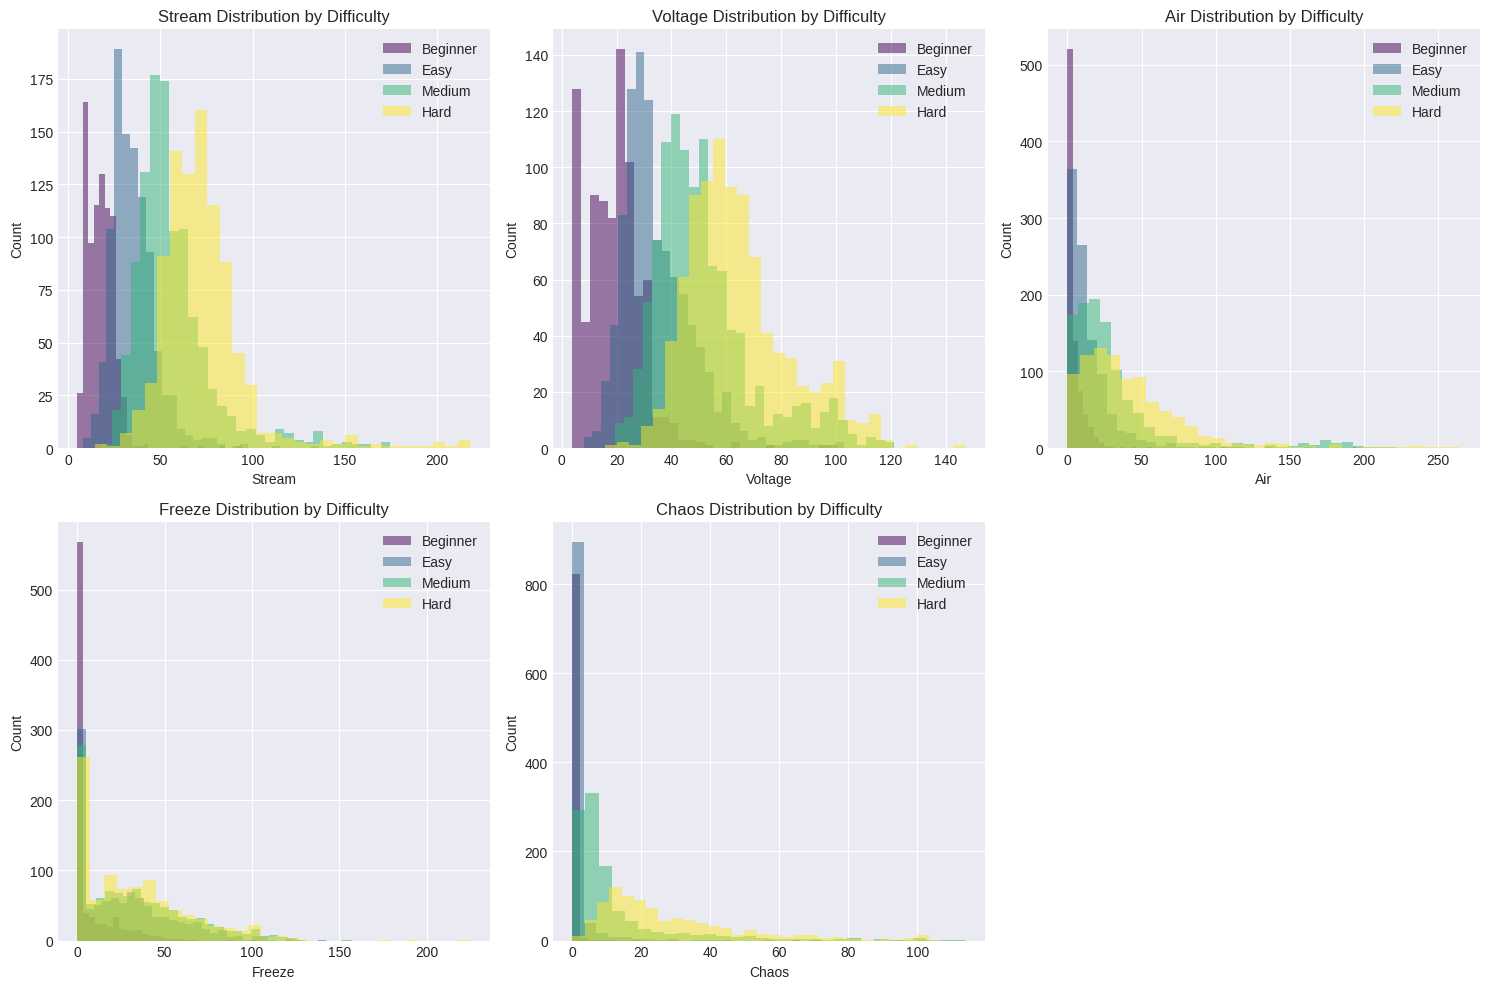

In [9]:
# Groove radar distributions by difficulty
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

colors = plt.cm.viridis(np.linspace(0, 1, len(DIFFICULTY_NAMES)))

for i, name in enumerate(radar_names):
    ax = axes[i]
    for diff_idx, diff_name in enumerate(DIFFICULTY_NAMES):
        mask = difficulties_arr == diff_idx
        if mask.sum() > 0:
            values = radar_raw[mask, i]
            ax.hist(values, bins=30, alpha=0.5, label=diff_name, color=colors[diff_idx])
    ax.set_xlabel(name)
    ax.set_ylabel('Count')
    ax.set_title(f'{name} Distribution by Difficulty')
    ax.legend()

# Hide unused subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

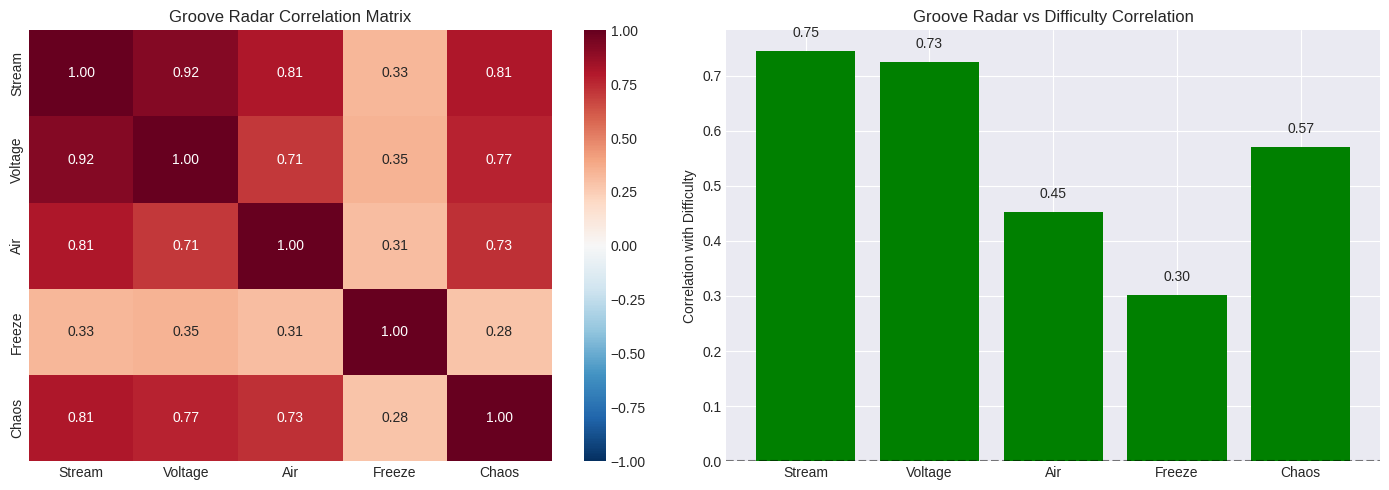

In [10]:
# Correlation heatmap between groove radar dimensions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Radar correlation
ax = axes[0]
corr = np.corrcoef(radar_raw.T)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            xticklabels=radar_names, yticklabels=radar_names, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Groove Radar Correlation Matrix')

# Radar-difficulty correlation
ax = axes[1]
radar_diff_corr = []
for i in range(5):
    corr_val = np.corrcoef(radar_raw[:, i], difficulties_arr)[0, 1]
    radar_diff_corr.append(corr_val)

bars = ax.bar(radar_names, radar_diff_corr, color=['green' if c > 0 else 'red' for c in radar_diff_corr])
ax.set_ylabel('Correlation with Difficulty')
ax.set_title('Groove Radar vs Difficulty Correlation')
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
for bar, val in zip(bars, radar_diff_corr):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02 * np.sign(val),
            f'{val:.2f}', ha='center', va='bottom' if val > 0 else 'top')

plt.tight_layout()
plt.show()

/tmp/ipykernel_271020/3263290043.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_diff, labels=DIFFICULTY_NAMES, patch_artist=True)
/tmp/ipykernel_271020/3263290043.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_diff, labels=DIFFICULTY_NAMES, patch_artist=True)
/tmp/ipykernel_271020/3263290043.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_diff, labels=DIFFICULTY_NAMES, patch_artist=True)
/tmp/ipykernel_271020/3263290043.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplo

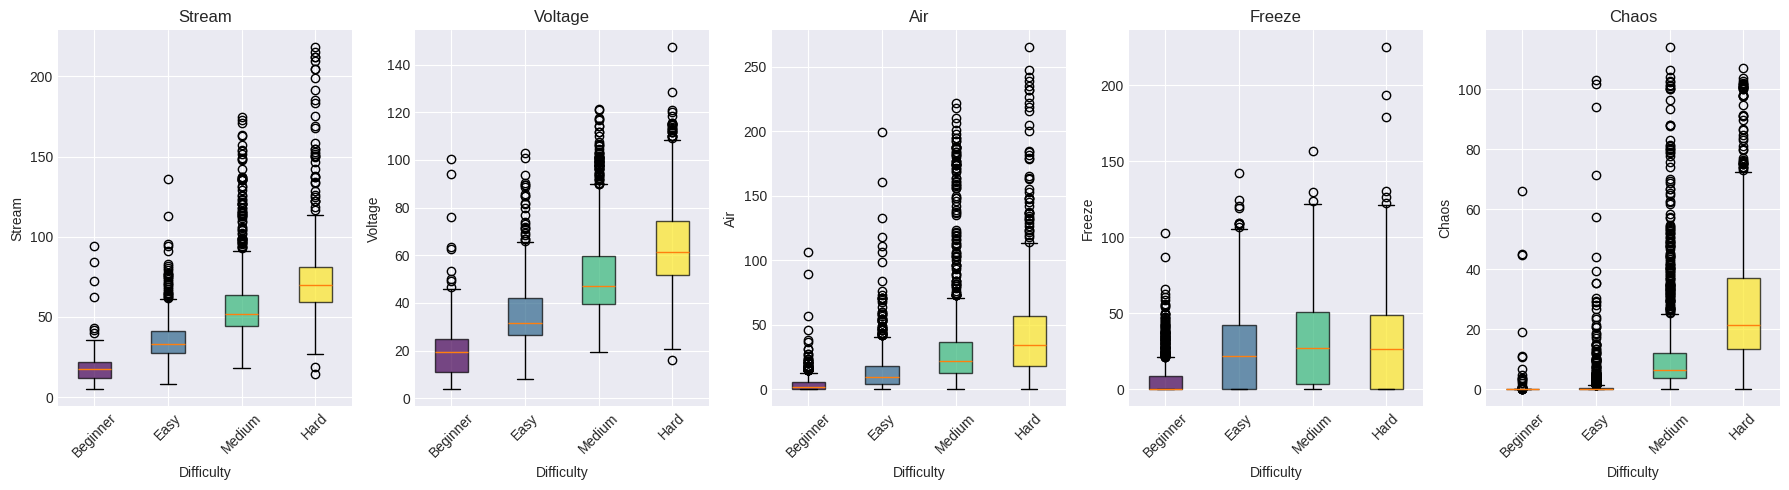

In [11]:
# Groove radar boxplot by difficulty
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

for i, name in enumerate(radar_names):
    ax = axes[i]
    data_by_diff = [radar_raw[difficulties_arr == d, i] for d in range(len(DIFFICULTY_NAMES))]
    bp = ax.boxplot(data_by_diff, labels=DIFFICULTY_NAMES, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_xlabel('Difficulty')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Triplet Selection Analysis

In [12]:
# Configure triplet selector
radar_weights = contrastive_config.get('radar_weights', [1.0, 1.0, 1.0, 1.0, 1.0])
similarity_fn = GrooveRadarSimilarity(weights=np.array(radar_weights))

triplet_selector = TripletSelector(
    similarity_fn=similarity_fn,
    positive_percentile=contrastive_config['positive_percentile'],
    negative_percentile=contrastive_config['negative_percentile'],
    same_difficulty_only=contrastive_config.get('same_difficulty_only', False),
    hard_mining=True
)

# Fit to training data
triplet_selector.fit(train_radars, train_difficulties)

print(f"Positive threshold: {triplet_selector.positive_threshold:.4f}")
print(f"Negative threshold: {triplet_selector.negative_threshold:.4f}")

TripletSelector fitted: positive_threshold=0.0475, negative_threshold=0.2958
Positive threshold: 0.0475
Negative threshold: 0.2958


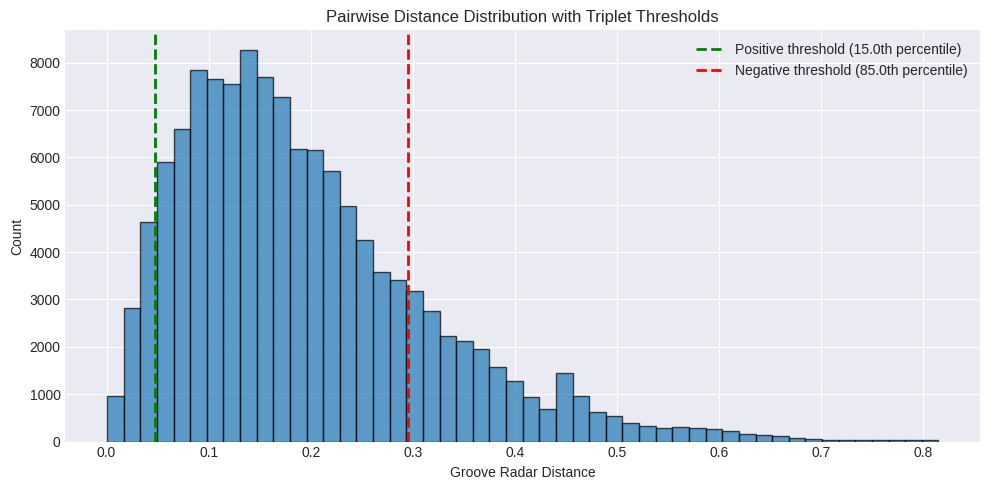

Distance stats: mean=0.1943, std=0.1233
Distance range: [0.0004, 0.8153]


In [13]:
# Visualize distance distribution and thresholds
# Sample pairwise distances
n_samples = min(500, len(train_radars))
sample_indices = np.random.choice(len(train_radars), n_samples, replace=False)

distances = []
for i in range(len(sample_indices)):
    for j in range(i + 1, len(sample_indices)):
        d = similarity_fn.distance(train_radars[sample_indices[i]], train_radars[sample_indices[j]])
        distances.append(d)

distances = np.array(distances)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(distances, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(triplet_selector.positive_threshold, color='green', linestyle='--', linewidth=2,
           label=f'Positive threshold ({triplet_selector.positive_percentile}th percentile)')
ax.axvline(triplet_selector.negative_threshold, color='red', linestyle='--', linewidth=2,
           label=f'Negative threshold ({triplet_selector.negative_percentile}th percentile)')
ax.set_xlabel('Groove Radar Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Distance Distribution with Triplet Thresholds')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Distance stats: mean={distances.mean():.4f}, std={distances.std():.4f}")
print(f"Distance range: [{distances.min():.4f}, {distances.max():.4f}]")

In [14]:
# Get triplet selection statistics
stats = triplet_selector.get_statistics(train_radars, train_difficulties)

print("Triplet Selection Statistics:")
print(f"  Total samples: {stats['total_samples']}")
print(f"  Samples with valid positives: {stats['has_positive']} ({stats['has_positive']/stats['total_samples']:.1%})")
print(f"  Samples with valid negatives: {stats['has_negative']} ({stats['has_negative']/stats['total_samples']:.1%})")
print(f"  Samples with both (valid anchors): {stats['has_both']} ({stats['valid_anchor_ratio']:.1%})")

Triplet Selection Statistics:
  Total samples: 3820
  Samples with valid positives: 3625 (94.9%)
  Samples with valid negatives: 3820 (100.0%)
  Samples with both (valid anchors): 3625 (94.9%)


## 5. Create Contrastive Dataset

In [15]:
# Create contrastive dataset
contrastive_train_dataset = create_contrastive_dataset(
    base_dataset=train_dataset,
    radar_weights=radar_weights,
    positive_percentile=contrastive_config['positive_percentile'],
    negative_percentile=contrastive_config['negative_percentile'],
    precompute=contrastive_config.get('precompute_triplets', True),
    resample=contrastive_config.get('resample_epoch', True)
)


triplet_stats = contrastive_train_dataset.get_triplet_statistics()
print(f"\nContrastive dataset:")
print(f"  Number of triplets: {triplet_stats['num_triplets']}")
print(f"  Base dataset size: {triplet_stats['base_dataset_size']}")

Fitting triplet selector...
TripletSelector fitted: positive_threshold=0.0800, negative_threshold=0.3286
Triplet selection stats: 3807/3820 (99.7%) samples can form valid triplets
Precomputing triplets...
Precomputed 3807 triplets

Contrastive dataset:
  Number of triplets: 3807
  Base dataset size: 3820


In [16]:
# Inspect a sample triplet
sample_triplet = contrastive_train_dataset[0]
print("Sample triplet keys:")
for key in sorted(sample_triplet.keys()):
    value = sample_triplet[key]
    if isinstance(value, torch.Tensor):
        print(f"  {key}: shape={tuple(value.shape)}, dtype={value.dtype}")
    else:
        print(f"  {key}: {type(value).__name__}")

Sample triplet keys:
  anchor_audio: shape=(1440, 23), dtype=torch.float32
  anchor_chart: shape=(1440, 4), dtype=torch.float32
  anchor_difficulty: shape=(), dtype=torch.int64
  anchor_difficulty_value: shape=(), dtype=torch.int64
  anchor_groove_radar: shape=(5,), dtype=torch.float32
  anchor_length: int
  anchor_mask: shape=(1440,), dtype=torch.bool
  negative_audio: shape=(1440, 23), dtype=torch.float32
  negative_chart: shape=(1440, 4), dtype=torch.float32
  negative_difficulty: shape=(), dtype=torch.int64
  negative_difficulty_value: shape=(), dtype=torch.int64
  negative_groove_radar: shape=(5,), dtype=torch.float32
  negative_length: int
  negative_mask: shape=(1440,), dtype=torch.bool
  positive_audio: shape=(1440, 23), dtype=torch.float32
  positive_chart: shape=(1440, 4), dtype=torch.float32
  positive_difficulty: shape=(), dtype=torch.int64
  positive_difficulty_value: shape=(), dtype=torch.int64
  positive_groove_radar: shape=(5,), dtype=torch.float32
  positive_length: in

In [17]:
# Create data loaders with optimized settings
batch_size = training_config['batch_size']
num_workers = 4
pin_memory = device.type == 'cuda'
persistent_workers = num_workers > 0
prefetch_factor = 4 if num_workers > 0 else None

train_loader = DataLoader(
    contrastive_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers,
    prefetch_factor=prefetch_factor,
    drop_last=True  # Consistent batch sizes for training
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers,
    prefetch_factor=prefetch_factor
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"DataLoader settings: persistent_workers={persistent_workers}, prefetch_factor={prefetch_factor}")

Train batches: 29
Val batches: 7
DataLoader settings: persistent_workers=True, prefetch_factor=4


## 6. Create Model with Projection Head

In [37]:
# Enable projection head for contrastive learning
model_config = classifier_config.copy()
model_config['use_projection_head'] = True
model_config['projection_dim'] = contrastive_config.get('projection_dim', 128)
model_config['use_groove_radar'] = True  # Use groove radar features

model = LateFusionClassifier(model_config)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created with projection head")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Projection dimension: {model_config['projection_dim']}")

Model created with projection head
  Total parameters: 2,818,916
  Trainable parameters: 2,818,916
  Projection dimension: 128


In [38]:
# Load pretrained classifier weights (optional)
PRETRAINED_CHECKPOINT = Path('../models/classifier/classifier_01_03_21-38/best_val_loss.pt')
LOAD_PRETRAINED = True  # Set to False to train from scratch
FREEZE_BACKBONE = False  # Set to True to freeze encoder/fusion/backbone

if LOAD_PRETRAINED and PRETRAINED_CHECKPOINT.exists():
    print(f"\nLoading pretrained weights from {PRETRAINED_CHECKPOINT}")
    
    # Load using the from_pretrained class method
    model = LateFusionClassifier.from_pretrained(
        checkpoint_path=str(PRETRAINED_CHECKPOINT),
        config=model_config,
        freeze_backbone=FREEZE_BACKBONE,
        device=str(device)
    )
    
    print("Pretrained weights loaded successfully!")
    print(f"  Freeze backbone: {FREEZE_BACKBONE}")
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"  Trainable: {trainable_params:,} / {total_params:,} parameters")
else:
    if not PRETRAINED_CHECKPOINT.exists():
        print(f"\nPretrained checkpoint not found at {PRETRAINED_CHECKPOINT}")
    print("\nTraining from scratch (no pretrained weights)")


Loading pretrained weights from ../models/classifier/classifier_01_03_21-38/best_val_loss.pt
Loaded pretrained weights from ../models/classifier/classifier_01_03_21-38/best_val_loss.pt
  Loaded: 114 parameters
  Missing (randomly initialized): 8 parameters
    Examples: ['radar_mlp.0.weight', 'radar_mlp.0.bias', 'radar_mlp.2.weight']
  Unexpected (ignored): 4 parameters
Pretrained weights loaded successfully!
  Freeze backbone: False
  Trainable: 2,818,916 / 2,818,916 parameters


In [39]:
# Test forward pass with a sample batch
sample_batch = next(iter(train_loader))

with torch.no_grad():
    anchor_audio = sample_batch['anchor_audio'].to(device)
    anchor_chart = sample_batch['anchor_chart'].to(device)
    anchor_mask = sample_batch['anchor_mask'].to(device)
    anchor_radar = sample_batch['anchor_groove_radar'].to(device)
    
    output = model(
        anchor_audio, anchor_chart, anchor_mask,
        groove_radar=anchor_radar,
        return_embeddings=True
    )

print(f"Forward pass successful!")
print(f"  Logits shape: {output['logits'].shape}")
print(f"  Embeddings shape: {output['embeddings'].shape}")

Forward pass successful!
  Logits shape: torch.Size([128, 4])
  Embeddings shape: torch.Size([128, 128])


## 7. Train with ContrastiveTrainer

In [40]:
# Create optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=training_config['learning_rate'],
    weight_decay=training_config.get('weight_decay', 0.01)
)

# Merge configs for trainer
trainer_config = {
    **training_config,
    **contrastive_config,
    'num_classes': classifier_config['num_classes'],
    'diagnostics': diagnostics_config
}

# Extract training schedule parameters
warmup_epochs = training_config.get('warmup_epochs', 0)
warmup_cls_weight = training_config.get('warmup_cls_weight', 0.0)
finetune_cls_weight = training_config.get('finetune_cls_weight', None)
selective_unfreeze = training_config.get('selective_unfreeze', None)

# Create trainer with new parameters
trainer = ContrastiveTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    config=trainer_config,
    checkpoint_dir=str(CHECKPOINT_DIR),
    device=device,
    warmup_epochs=warmup_epochs,
    warmup_cls_weight=warmup_cls_weight,
    finetune_cls_weight=finetune_cls_weight,
    selective_unfreeze=selective_unfreeze
)

print(f"\nContrastiveTrainer initialized for Experiment {EXPERIMENT}")
print(f"  Classification weight: {trainer.classification_weight}")
print(f"  Contrastive weight: {trainer.contrastive_weight}")
if warmup_epochs > 0:
    print(f"  Warmup: {warmup_epochs} epochs with cls_weight={warmup_cls_weight}")
    print(f"  Fine-tune: cls_weight={finetune_cls_weight}")
if selective_unfreeze:
    print(f"  Selective unfreezing: {selective_unfreeze}")

Using device: cuda
Using mixed precision training (AMP)
Using gradient accumulation: 2 steps
Using class weights: [1.1423444747924805, 0.9646464586257935, 0.8809962868690491, 1.0494505167007446]
Selective unfreezing enabled: ['fusion_module', 'backbone', 'pooling', 'classifier_head', 'projection_head', 'radar_mlp']
  Selective freeze: 2,685,860 / 2,818,916 parameters trainable
Using multi-task loss: 0.8*classification + 2.0*contrastive (triplet_radar)
Training diagnostics enabled, saving to ../checkpoints/contrastive/diagnostics

ContrastiveTrainer initialized for Experiment B
  Classification weight: 0.8
  Contrastive weight: 2.0
  Selective unfreezing: ['fusion_module', 'backbone', 'pooling', 'classifier_head', 'projection_head', 'radar_mlp']


In [22]:
# Optional: Load from checkpoint to resume training
resume_checkpoint = CHECKPOINT_DIR  # Set to path to resume, e.g., CHECKPOINT_DIR / 'last.pt'

if resume_checkpoint and Path(resume_checkpoint).exists():
    trainer.load_checkpoint(str(resume_checkpoint))
    print(f"Resumed from {resume_checkpoint}")

IsADirectoryError: [Errno 21] Is a directory: '../checkpoints/contrastive'

In [41]:
# Train!
history = trainer.fit()

Starting contrastive training for 20 epochs (from epoch 1)
Checkpoints will be saved to: ../checkpoints/contrastive


Train Epoch 1: 100%|█| 29/29 [00:17<00:00,  1.66it/s, loss=2.8896, cls=0.4982, c
Val Epoch 1: 100%|███████| 7/7 [00:00<00:00, 12.36it/s, loss=0.6200, acc=0.7684]


Epoch 1:
  Train Loss: 3.7853 (cls: 0.5089, ctr: 1.6891)
  Train Acc: 0.8262
  Val Loss: 0.5781, Val Acc: 0.7684
  LR: 0.000100
  New best validation loss: 0.5781


Train Epoch 2: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=3.0740, cls=0.4978, c
Val Epoch 2: 100%|███████| 7/7 [00:00<00:00, 12.33it/s, loss=0.6274, acc=0.7684]


Epoch 2:
  Train Loss: 3.1879 (cls: 0.4737, ctr: 1.4045)
  Train Acc: 0.8314
  Val Loss: 0.5760, Val Acc: 0.7684
  LR: 0.000100
  New best validation loss: 0.5760


Train Epoch 3: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=2.6235, cls=0.4463, c
Val Epoch 3: 100%|███████| 7/7 [00:00<00:00, 12.02it/s, loss=0.6459, acc=0.7735]


Epoch 3:
  Train Loss: 2.4808 (cls: 0.4761, ctr: 1.0500)
  Train Acc: 0.8225
  Val Loss: 0.5650, Val Acc: 0.7735
  LR: 0.000100
  New best validation loss: 0.5650


Train Epoch 4: 100%|█| 29/29 [00:17<00:00,  1.67it/s, loss=0.5853, cls=0.4325, c
Val Epoch 4: 100%|███████| 7/7 [00:00<00:00, 12.45it/s, loss=0.6899, acc=0.7697]


Epoch 4:
  Train Loss: 1.3938 (cls: 0.4750, ctr: 0.5069)
  Train Acc: 0.8273
  Val Loss: 0.5719, Val Acc: 0.7697
  LR: 0.000100


Train Epoch 5: 100%|█| 29/29 [00:17<00:00,  1.67it/s, loss=0.6805, cls=0.5066, c
Val Epoch 5: 100%|███████| 7/7 [00:00<00:00, 12.36it/s, loss=0.6389, acc=0.7863]


  Embedding drift: cosine_sim=1.0000, l2_dist=0.0000
Epoch 5:
  Train Loss: 0.6371 (cls: 0.4691, ctr: 0.1309)
  Train Acc: 0.8200
  Val Loss: 0.5428, Val Acc: 0.7863
  LR: 0.000100
  New best validation loss: 0.5428


Train Epoch 6: 100%|█| 29/29 [00:17<00:00,  1.67it/s, loss=0.3510, cls=0.4388, c
Val Epoch 6: 100%|███████| 7/7 [00:00<00:00, 12.77it/s, loss=0.7440, acc=0.7761]


Epoch 6:
  Train Loss: 0.4162 (cls: 0.4662, ctr: 0.0216)
  Train Acc: 0.8287
  Val Loss: 0.5901, Val Acc: 0.7761
  LR: 0.000100


Train Epoch 7: 100%|█| 29/29 [00:17<00:00,  1.66it/s, loss=0.4368, cls=0.5460, c
Val Epoch 7: 100%|███████| 7/7 [00:00<00:00, 11.90it/s, loss=0.7277, acc=0.7659]


Epoch 7:
  Train Loss: 0.3899 (cls: 0.4722, ctr: 0.0061)
  Train Acc: 0.8184
  Val Loss: 0.5840, Val Acc: 0.7659
  LR: 0.000100


Train Epoch 8: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=0.4435, cls=0.4936, c
Val Epoch 8: 100%|███████| 7/7 [00:00<00:00, 12.07it/s, loss=0.6698, acc=0.7761]


Epoch 8:
  Train Loss: 0.3684 (cls: 0.4506, ctr: 0.0040)
  Train Acc: 0.8257
  Val Loss: 0.5589, Val Acc: 0.7761
  LR: 0.000100


Train Epoch 9: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=0.3622, cls=0.4432, c
Val Epoch 9: 100%|███████| 7/7 [00:00<00:00, 12.79it/s, loss=0.6980, acc=0.7863]


Epoch 9:
  Train Loss: 0.3628 (cls: 0.4469, ctr: 0.0026)
  Train Acc: 0.8322
  Val Loss: 0.5654, Val Acc: 0.7863
  LR: 0.000100


Train Epoch 10: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=0.3272, cls=0.4090, 
Val Epoch 10: 100%|██████| 7/7 [00:00<00:00, 12.56it/s, loss=0.7411, acc=0.7748]


  Embedding drift: cosine_sim=0.9526, l2_dist=2.7773
Epoch 10:
  Train Loss: 0.3610 (cls: 0.4422, ctr: 0.0036)
  Train Acc: 0.8305
  Val Loss: 0.5785, Val Acc: 0.7748
  LR: 0.000100


Train Epoch 11: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=0.4029, cls=0.5037, 
Val Epoch 11: 100%|██████| 7/7 [00:00<00:00, 12.83it/s, loss=0.6605, acc=0.7799]


Epoch 11:
  Train Loss: 0.3584 (cls: 0.4435, ctr: 0.0018)
  Train Acc: 0.8297
  Val Loss: 0.5487, Val Acc: 0.7799
  LR: 0.000100


Train Epoch 12: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=0.3902, cls=0.4877, 
Val Epoch 12: 100%|██████| 7/7 [00:00<00:00, 12.79it/s, loss=0.7088, acc=0.7723]


Epoch 12:
  Train Loss: 0.3625 (cls: 0.4442, ctr: 0.0036)
  Train Acc: 0.8287
  Val Loss: 0.5787, Val Acc: 0.7723
  LR: 0.000050


Train Epoch 13: 100%|█| 29/29 [00:17<00:00,  1.67it/s, loss=0.3139, cls=0.3924, 
Val Epoch 13: 100%|██████| 7/7 [00:00<00:00, 12.68it/s, loss=0.6879, acc=0.7710]


Epoch 13:
  Train Loss: 0.3504 (cls: 0.4372, ctr: 0.0003)
  Train Acc: 0.8359
  Val Loss: 0.5694, Val Acc: 0.7710
  LR: 0.000050


Train Epoch 14: 100%|█| 29/29 [00:17<00:00,  1.66it/s, loss=0.2731, cls=0.3413, 
Val Epoch 14: 100%|██████| 7/7 [00:00<00:00, 12.62it/s, loss=0.6719, acc=0.7710]


Epoch 14:
  Train Loss: 0.3461 (cls: 0.4287, ctr: 0.0016)
  Train Acc: 0.8373
  Val Loss: 0.5649, Val Acc: 0.7710
  LR: 0.000050


Train Epoch 15: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=0.4168, cls=0.5210, 
Val Epoch 15: 100%|██████| 7/7 [00:00<00:00, 12.25it/s, loss=0.6475, acc=0.7850]


  Embedding drift: cosine_sim=0.9634, l2_dist=2.5566
Epoch 15:
  Train Loss: 0.3521 (cls: 0.4335, ctr: 0.0027)
  Train Acc: 0.8324
  Val Loss: 0.5505, Val Acc: 0.7850
  LR: 0.000050


Train Epoch 16: 100%|█| 29/29 [00:17<00:00,  1.67it/s, loss=0.3848, cls=0.4811, 
Val Epoch 16: 100%|██████| 7/7 [00:00<00:00, 12.39it/s, loss=0.5978, acc=0.7926]


Epoch 16:
  Train Loss: 0.3436 (cls: 0.4269, ctr: 0.0010)
  Train Acc: 0.8324
  Val Loss: 0.5225, Val Acc: 0.7926
  LR: 0.000050
  New best validation loss: 0.5225


Train Epoch 17: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=0.4118, cls=0.5148, 
Val Epoch 17: 100%|██████| 7/7 [00:00<00:00, 12.25it/s, loss=0.7118, acc=0.7634]


Epoch 17:
  Train Loss: 0.3405 (cls: 0.4203, ctr: 0.0021)
  Train Acc: 0.8400
  Val Loss: 0.5952, Val Acc: 0.7634
  LR: 0.000050


Train Epoch 18: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=0.3701, cls=0.4626, 
Val Epoch 18: 100%|██████| 7/7 [00:00<00:00, 12.44it/s, loss=0.6425, acc=0.7774]


Epoch 18:
  Train Loss: 0.3354 (cls: 0.4173, ctr: 0.0008)
  Train Acc: 0.8443
  Val Loss: 0.5557, Val Acc: 0.7774
  LR: 0.000050


Train Epoch 19: 100%|█| 29/29 [00:17<00:00,  1.68it/s, loss=0.4277, cls=0.5346, 
Val Epoch 19: 100%|██████| 7/7 [00:00<00:00, 13.17it/s, loss=0.6588, acc=0.7786]


Epoch 19:
  Train Loss: 0.3435 (cls: 0.4150, ctr: 0.0057)
  Train Acc: 0.8413
  Val Loss: 0.5634, Val Acc: 0.7786
  LR: 0.000050


Train Epoch 20: 100%|█| 29/29 [00:17<00:00,  1.67it/s, loss=0.2553, cls=0.3191, 
Val Epoch 20: 100%|██████| 7/7 [00:00<00:00, 12.35it/s, loss=0.6970, acc=0.7672]


  Embedding drift: cosine_sim=0.9238, l2_dist=3.5859
Epoch 20:
  Train Loss: 0.3404 (cls: 0.4158, ctr: 0.0039)
  Train Acc: 0.8400
  Val Loss: 0.5818, Val Acc: 0.7672
  LR: 0.000050
Contrastive training completed!

Generating diagnostic plots...
Saved diagnostics summary to ../checkpoints/contrastive/diagnostics/diagnostics_summary.json


## 8. Training Analysis

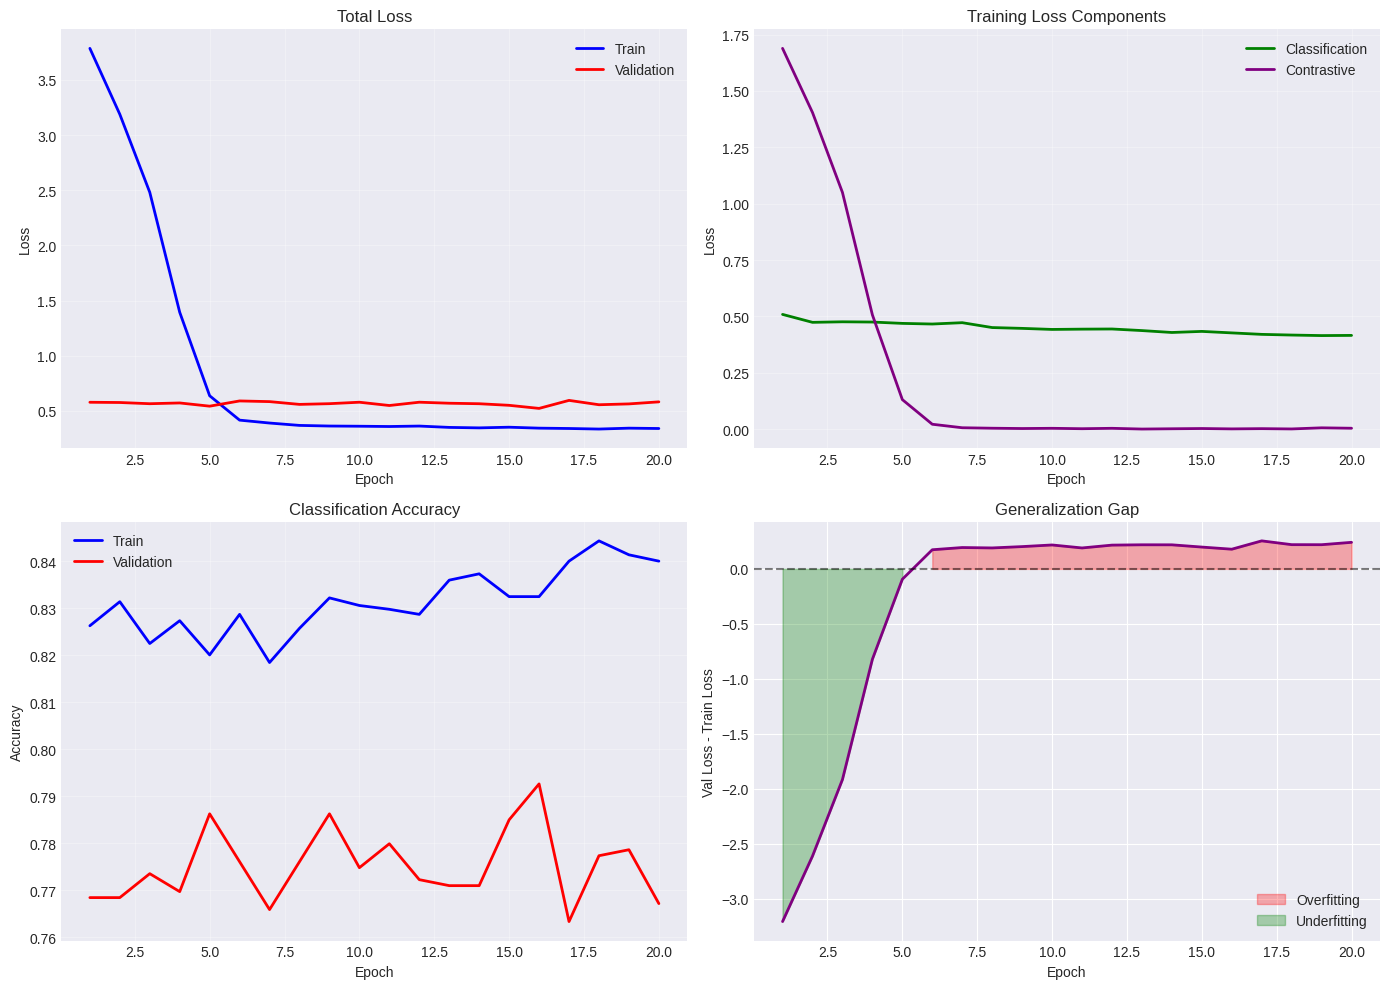


Training Summary:
  Best validation loss: 0.5225
  Best validation accuracy: 0.7926
  Final train accuracy: 0.8400
  Final val accuracy: 0.7672


In [42]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Total loss
ax = axes[0, 0]
ax.plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
ax.plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Total Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Component losses
ax = axes[0, 1]
ax.plot(epochs, history['train_cls_loss'], 'g-', label='Classification', linewidth=2)
ax.plot(epochs, history['train_contrastive_loss'], 'purple', label='Contrastive', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Components')
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy
ax = axes[1, 0]
ax.plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
ax.plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Classification Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Generalization gap
ax = axes[1, 1]
gap = np.array(history['val_loss']) - np.array(history['train_loss'])
ax.plot(epochs, gap, 'purple', linewidth=2)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.fill_between(epochs, 0, gap, where=(gap > 0), color='red', alpha=0.3, label='Overfitting')
ax.fill_between(epochs, 0, gap, where=(gap <= 0), color='green', alpha=0.3, label='Underfitting')
ax.set_xlabel('Epoch')
ax.set_ylabel('Val Loss - Train Loss')
ax.set_title('Generalization Gap')
ax.legend()

plt.tight_layout()
plt.show()

# Print summary
print(f"\nTraining Summary:")
print(f"  Best validation loss: {min(history['val_loss']):.4f}")
print(f"  Best validation accuracy: {max(history['val_acc']):.4f}")
print(f"  Final train accuracy: {history['train_acc'][-1]:.4f}")
print(f"  Final val accuracy: {history['val_acc'][-1]:.4f}")

In [43]:
# ===== DIAGNOSTIC VISUALIZATIONS =====

if diagnostics_config.get('enabled', False):
    print("Loading diagnostic results...")
    
    # Load diagnostic summary
    summary_path = CHECKPOINT_DIR / 'diagnostics' / 'diagnostics_summary.json'
    if summary_path.exists():
        with open(summary_path, 'r') as f:
            diagnostic_summary = json.load(f)
        
        print("\n=== Diagnostic Summary ===")
        print(f"Total epochs: {diagnostic_summary['total_epochs']}")
        
        print("\n--- Gradient Norms ---")
        for module, stats in diagnostic_summary['gradient_norms'].items():
            print(f"  {module}:")
            print(f"    Initial: {stats['initial']:.6f}, Final: {stats['final']:.6f}")
            print(f"    Change: {stats['final']/stats['initial']:.2f}x")
        
        print("\n--- Triplet Statistics ---")
        if diagnostic_summary['triplet_stats']:
            ts = diagnostic_summary['triplet_stats']
            print(f"  Initial margin: {ts['initial_margin']:.4f}")
            print(f"  Final margin: {ts['final_margin']:.4f}")
            print(f"  Improvement: +{ts['margin_improvement']:.4f}")
        
        print("\n--- Embedding Drift ---")
        if diagnostic_summary['embedding_drift']:
            ed = diagnostic_summary['embedding_drift']
            print(f"  Final cosine similarity: {ed['final_cosine_similarity']:.4f}")
            print(f"  Final L2 distance: {ed['final_l2_distance']:.4f}")
    else:
        print(f"No diagnostic summary found at {summary_path}")
    
    # Display diagnostic plots
    plots_path = CHECKPOINT_DIR / 'diagnostics' / 'training_curves.png'
    if plots_path.exists():
        print(f"\nDisplaying diagnostic plots from {plots_path}")
        from IPython.display import Image, display
        display(Image(str(plots_path)))
    else:
        print(f"No diagnostic plots found at {plots_path}")
else:
    print("Diagnostics were not enabled for this training run.")

Loading diagnostic results...

=== Diagnostic Summary ===
Total epochs: 0

--- Gradient Norms ---

--- Triplet Statistics ---

--- Embedding Drift ---
  Final cosine similarity: 0.9238
  Final L2 distance: 3.5859
No diagnostic plots found at ../checkpoints/contrastive/diagnostics/training_curves.png


## 9. Embedding Space Visualization

Use t-SNE to visualize the learned embedding space.

In [44]:
# Extract embeddings from validation set
@torch.no_grad()
def extract_embeddings(model, dataloader, device, max_samples=500):
    """Extract embeddings and labels from a dataloader."""
    model.eval()
    
    all_embeddings = []
    all_labels = []
    all_groove_radars = []
    
    total = 0
    for batch in tqdm(dataloader, desc="Extracting embeddings"):
        audio = batch['audio'].to(device)
        chart = batch['chart'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['difficulty']
        groove_radar = batch.get('groove_radar')
        if groove_radar is not None:
            groove_radar = groove_radar.to(device)
        
        output = model(audio, chart, mask, groove_radar=groove_radar, return_embeddings=True)
        
        all_embeddings.append(output['embeddings'].cpu().numpy())
        all_labels.append(labels.numpy())
        if groove_radar is not None:
            all_groove_radars.append(groove_radar.cpu().numpy())
        
        total += labels.size(0)
        if total >= max_samples:
            break
    
    embeddings = np.concatenate(all_embeddings, axis=0)[:max_samples]
    labels = np.concatenate(all_labels, axis=0)[:max_samples]
    groove_radars = np.concatenate(all_groove_radars, axis=0)[:max_samples] if all_groove_radars else None
    
    return embeddings, labels, groove_radars

embeddings, labels, groove_radars = extract_embeddings(model, val_loader, device)
print(f"Extracted {len(embeddings)} embeddings")

Extracting embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

Extracted 500 embeddings


In [45]:
# Apply t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)
print("t-SNE complete!")

Running t-SNE...
t-SNE complete!


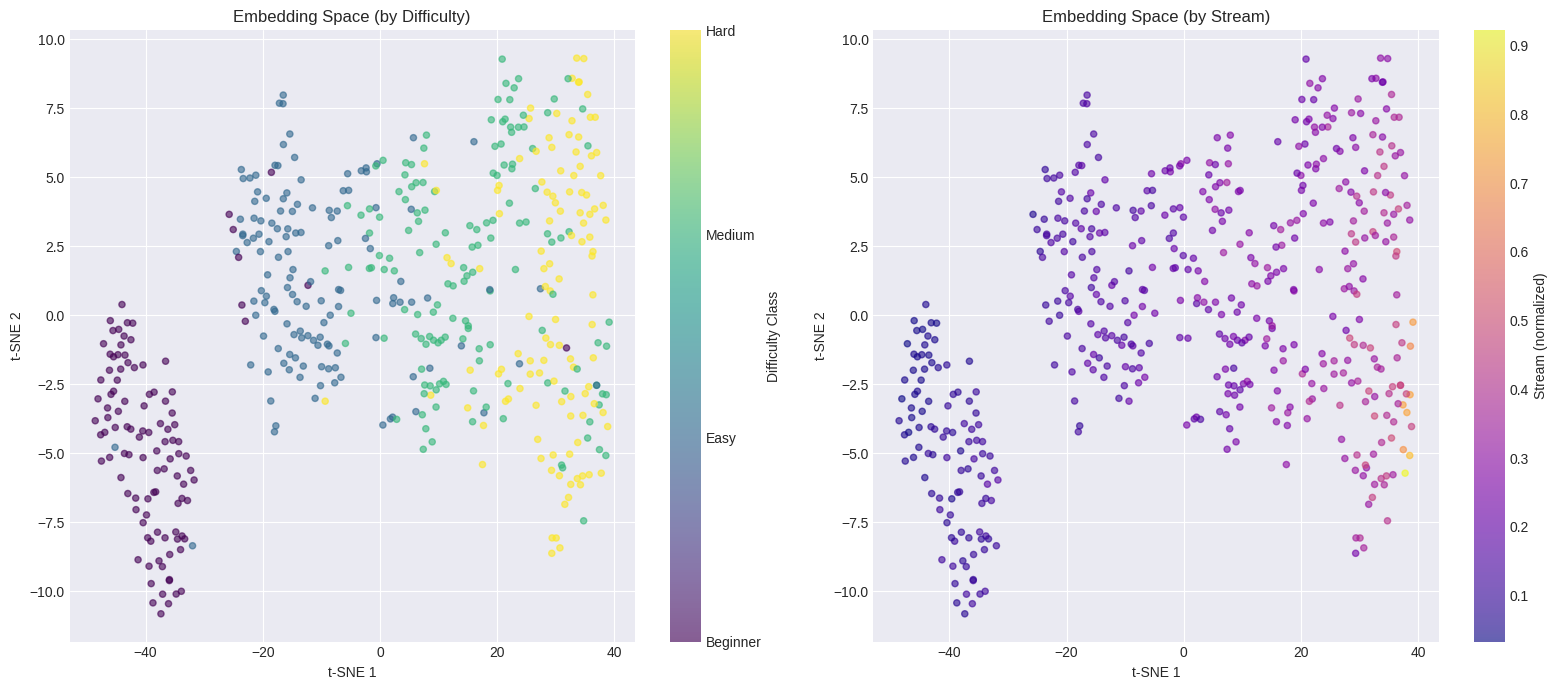

In [46]:
# Visualize t-SNE embeddings colored by difficulty
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# By difficulty class
ax = axes[0]
scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=labels, cmap='viridis', alpha=0.6, s=20)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Difficulty Class')
cbar.set_ticks(range(len(DIFFICULTY_NAMES)))
cbar.set_ticklabels(DIFFICULTY_NAMES)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('Embedding Space (by Difficulty)')

# By Stream (first groove radar component)
ax = axes[1]
if groove_radars is not None:
    stream_values = groove_radars[:, 0]  # First component (Stream) - already normalized
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=stream_values, cmap='plasma', alpha=0.6, s=20)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Stream (normalized)')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title('Embedding Space (by Stream)')
else:
    ax.text(0.5, 0.5, 'No groove radar data', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

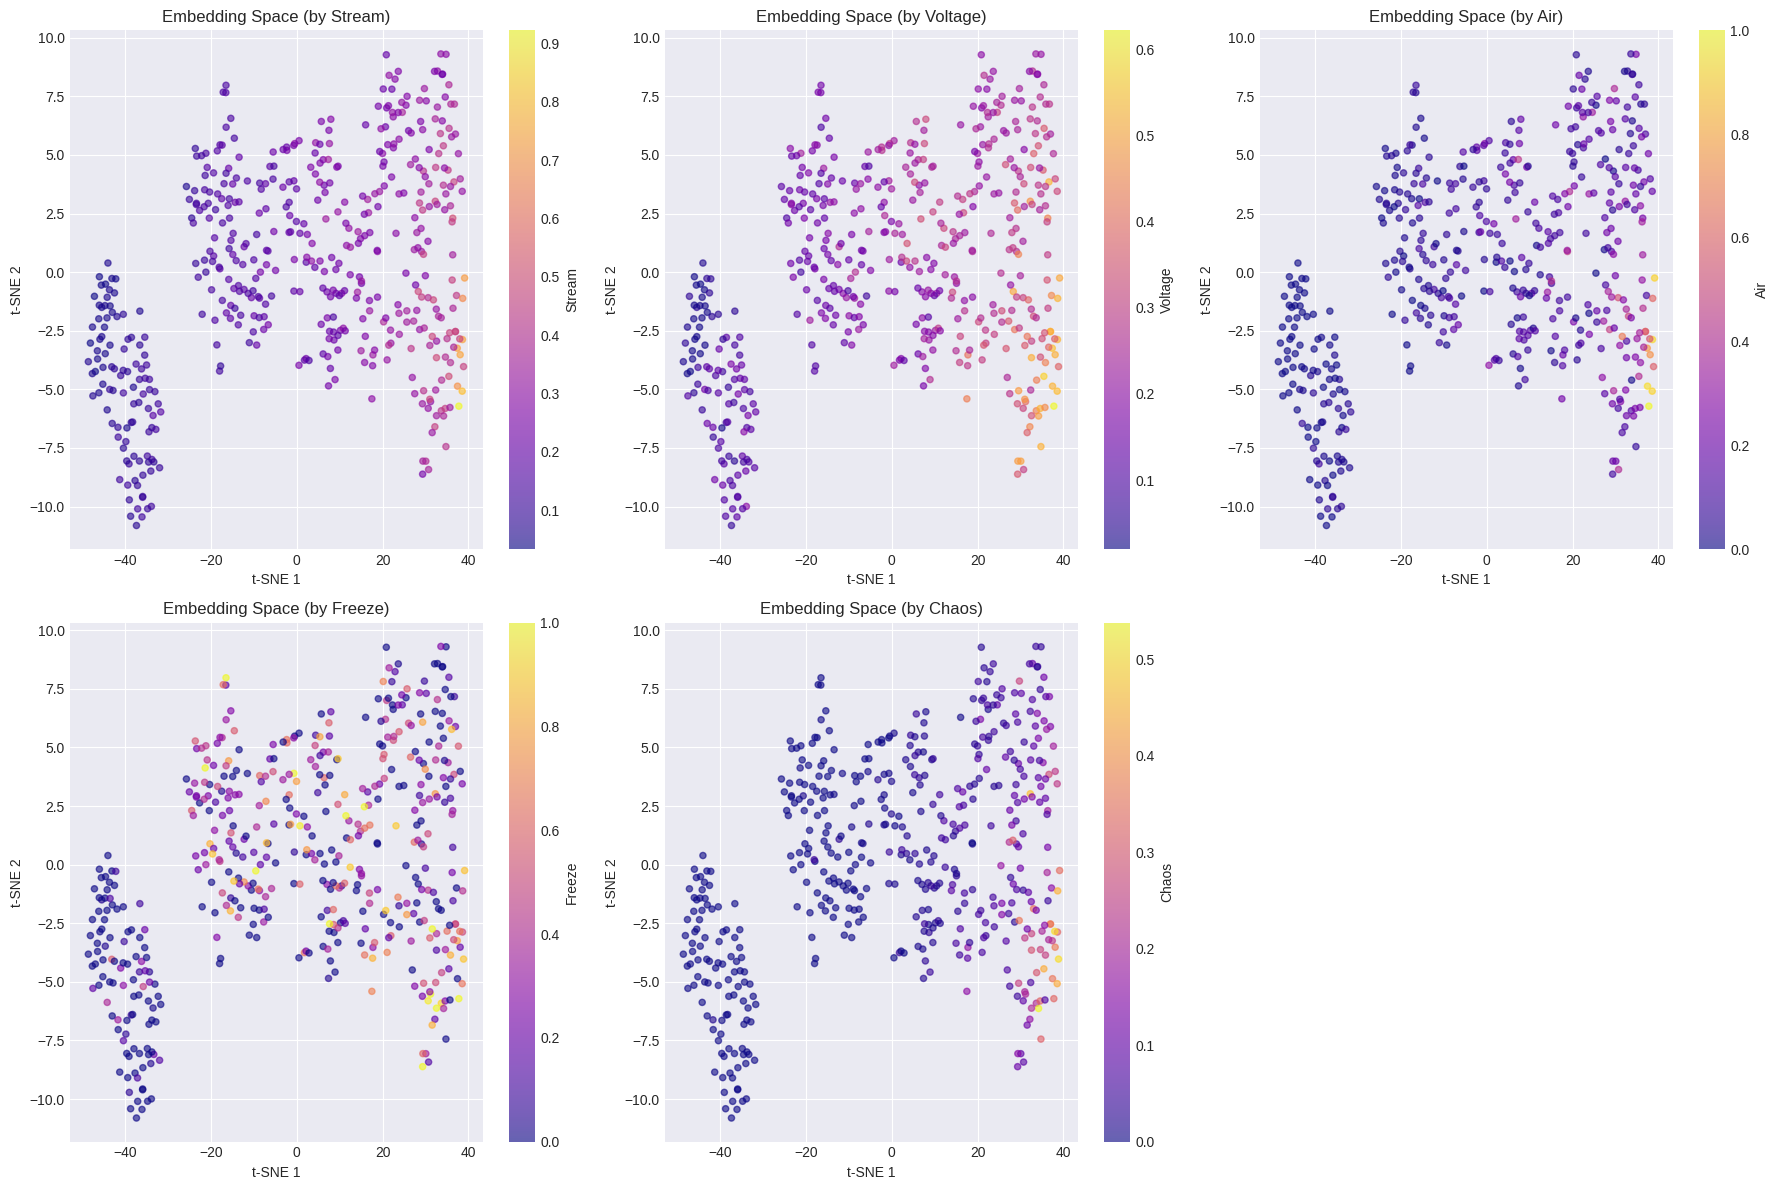

In [47]:
# Embedding space colored by each groove radar dimension
if groove_radars is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (ax, name) in enumerate(zip(axes[:5], radar_names)):
        scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                            c=groove_radars[:, i], cmap='plasma', alpha=0.6, s=20)
        plt.colorbar(scatter, ax=ax, label=name)
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        ax.set_title(f'Embedding Space (by {name})')
    
    axes[5].axis('off')
    plt.tight_layout()
    plt.show()

## 10. Triplet Quality Analysis

Analyze how well the contrastive learning is separating samples.

In [48]:
# Compute embedding distances for triplets
@torch.no_grad()
def analyze_triplet_distances(model, train_loader, device, n_batches=10):
    """Analyze distances between anchor-positive and anchor-negative in embedding space."""
    model.eval()
    
    ap_distances = []  # Anchor-Positive distances
    an_distances = []  # Anchor-Negative distances
    
    for i, batch in enumerate(train_loader):
        if i >= n_batches:
            break
            
        # Get embeddings for anchor, positive, negative
        anchor_out = model(
            batch['anchor_audio'].to(device),
            batch['anchor_chart'].to(device),
            batch['anchor_mask'].to(device),
            groove_radar=batch['anchor_groove_radar'].to(device),
            return_embeddings=True
        )
        positive_out = model(
            batch['positive_audio'].to(device),
            batch['positive_chart'].to(device),
            batch['positive_mask'].to(device),
            groove_radar=batch['positive_groove_radar'].to(device),
            return_embeddings=True
        )
        negative_out = model(
            batch['negative_audio'].to(device),
            batch['negative_chart'].to(device),
            batch['negative_mask'].to(device),
            groove_radar=batch['negative_groove_radar'].to(device),
            return_embeddings=True
        )
        
        # Compute distances
        ap_dist = torch.norm(anchor_out['embeddings'] - positive_out['embeddings'], dim=1)
        an_dist = torch.norm(anchor_out['embeddings'] - negative_out['embeddings'], dim=1)
        
        ap_distances.extend(ap_dist.cpu().numpy().tolist())
        an_distances.extend(an_dist.cpu().numpy().tolist())
    
    return np.array(ap_distances), np.array(an_distances)

ap_distances, an_distances = analyze_triplet_distances(model, train_loader, device)
print(f"Analyzed {len(ap_distances)} triplets")

Analyzed 1280 triplets


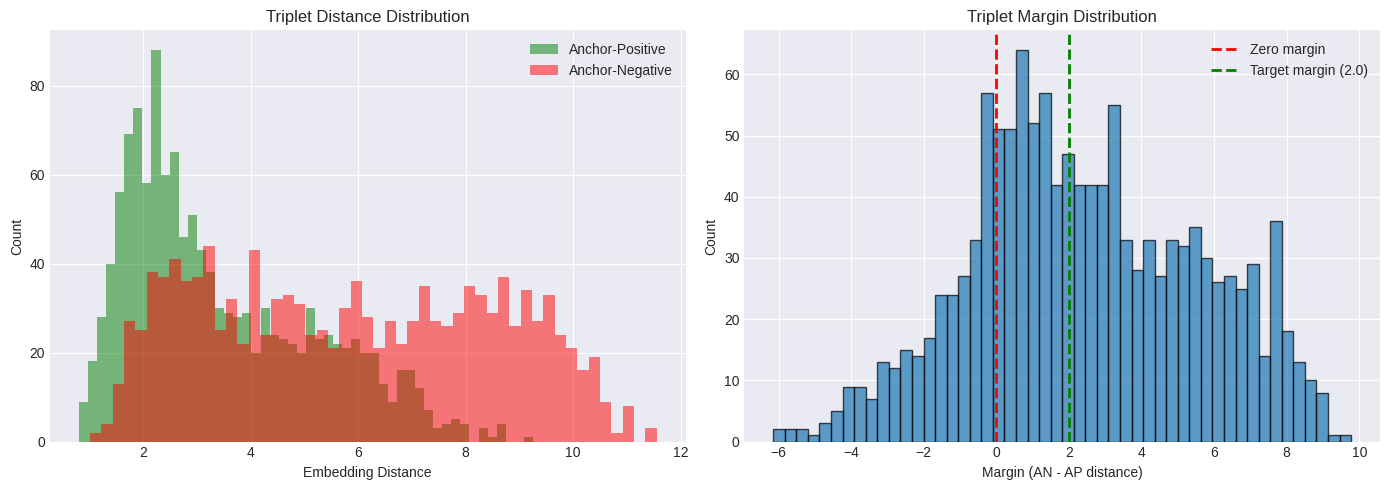


Triplet Statistics:
  Mean AP distance: 3.4489
  Mean AN distance: 5.8684
  Mean margin: 2.4195
  Triplets with positive margin: 988/1280 (77.2%)


In [49]:
# Plot distance distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
ax.hist(ap_distances, bins=50, alpha=0.5, label='Anchor-Positive', color='green')
ax.hist(an_distances, bins=50, alpha=0.5, label='Anchor-Negative', color='red')
ax.set_xlabel('Embedding Distance')
ax.set_ylabel('Count')
ax.set_title('Triplet Distance Distribution')
ax.legend()

# Margin analysis
ax = axes[1]
margins = an_distances - ap_distances
ax.hist(margins, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero margin')
ax.axvline(contrastive_config['triplet_margin'], color='green', linestyle='--', 
           linewidth=2, label=f'Target margin ({contrastive_config["triplet_margin"]})')
ax.set_xlabel('Margin (AN - AP distance)')
ax.set_ylabel('Count')
ax.set_title('Triplet Margin Distribution')
ax.legend()

plt.tight_layout()
plt.show()

# Statistics
satisfied = (margins > 0).sum()
print(f"\nTriplet Statistics:")
print(f"  Mean AP distance: {ap_distances.mean():.4f}")
print(f"  Mean AN distance: {an_distances.mean():.4f}")
print(f"  Mean margin: {margins.mean():.4f}")
print(f"  Triplets with positive margin: {satisfied}/{len(margins)} ({satisfied/len(margins):.1%})")

## 11. Save Results

In [50]:
# Save final results summary
results = {
    'training_config': trainer_config,
    'best_val_loss': min(history['val_loss']),
    'best_val_acc': max(history['val_acc']),
    'final_train_acc': history['train_acc'][-1],
    'final_val_acc': history['val_acc'][-1],
    'num_epochs': len(history['train_loss']),
    'triplet_stats': {
        'mean_ap_distance': float(ap_distances.mean()),
        'mean_an_distance': float(an_distances.mean()),
        'mean_margin': float(margins.mean()),
        'positive_margin_ratio': float(satisfied / len(margins))
    }
}

results_path = CHECKPOINT_DIR / 'training_results.yaml'
with open(results_path, 'w') as f:
    yaml.dump(results, f, default_flow_style=False)

print(f"Results saved to {results_path}")

Results saved to ../checkpoints/contrastive/training_results.yaml


In [51]:
print("\n" + "="*50)
print("CONTRASTIVE TRAINING COMPLETE")
print("="*50)
print(f"\nCheckpoints saved to: {CHECKPOINT_DIR}")
print(f"Best model: {CHECKPOINT_DIR / 'best_val_loss.pt'}")
print(f"\nFinal Results:")
print(f"  Validation Accuracy: {results['best_val_acc']:.4f}")
print(f"  Triplet Margin Ratio: {results['triplet_stats']['positive_margin_ratio']:.1%}")


CONTRASTIVE TRAINING COMPLETE

Checkpoints saved to: ../checkpoints/contrastive
Best model: ../checkpoints/contrastive/best_val_loss.pt

Final Results:
  Validation Accuracy: 0.7926
  Triplet Margin Ratio: 77.2%
